In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing required packages
import pandas as pd
import numpy as np

import os
import gc


from ta_lib.regression.estimators import SKLStatsmodelOLS
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import openpyxl
import xlsxwriter
# import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")

In [6]:
# from ta_lib.core.api import load_yml, create_context,_change_permissions_recursive

In [7]:
# Defining configs
config_path = '../conf/config.yml'
config = create_context(config_path)
cfg = config.offline

In [8]:

include_105=True
st_dt='2020-12-01'
en_dt='2021-11-30'
df_store = pd.read_csv(cfg['STORE_MASTER'].format(**cfg))
dict_store = dict(zip(df_store["busn_lcat_id_nu"],df_store["mcd_gbal_lcat_id_nu"]))
offline_input_path = cfg['OFFLINE_RAW'].format(**cfg)
offline_input_path_105 = cfg['OFFLINE_RAW_105'].format(**cfg)
digital_input_path = cfg['DIGITAL_TRNS'].format(**cfg)
digital_input_path_offer = cfg['DIGITAL_OFFER_TRNS'].format(**cfg)
output_path = cfg['DIGITAL_OFFER_UNITS'].format(**cfg)
grouper_cols = ['sld_menu_itm_id', 'pos_busn_dt']
# Getting file list and initialising other variables
file_list = ['month_id=' + x + '01' for x in pd.date_range(st_dt, en_dt, freq='MS').strftime("%Y%m").tolist()]
file_list.sort(reverse=True)

In [9]:
file_list

['month_id=20211101',
 'month_id=20211001',
 'month_id=20210901',
 'month_id=20210801',
 'month_id=20210701',
 'month_id=20210601',
 'month_id=20210501',
 'month_id=20210401',
 'month_id=20210301',
 'month_id=20210201',
 'month_id=20210101',
 'month_id=20201201']

In [28]:
cfg['DIGITAL_OFFER_UNITS'].format(**cfg)

'/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/processed/digital/digital_offers/offer_units/'

In [10]:
# digital_input_path_offer

In [11]:
master_path = '/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/raw/master_data/'

In [12]:
# pd.read_parquetr("/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/raw/digital/trns_all_offers/month_id=202012/")

In [13]:
# pd.read_parquet("/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/raw/digital/trans_ids_with_offer_flag/month_id=202011/")

In [14]:
dig_offers = pd.read_excel(f'{master_path}Digital_Promo_Funnel.xlsx')

In [15]:
# dig_offers = pd.read_excel("dig_offer_cal.xlsx")
dict_offer={}
for itm in dig_offers.sld_menu_itm_id.unique():
    dict_offer[itm] = list(dig_offers[dig_offers.sld_menu_itm_id==itm].offer_id.unique())
items =list(dig_offers.sld_menu_itm_id.unique())

In [16]:
len(items)

83

In [17]:
def is_offer_valid(row):
    return(row["offer_id"] in dict_offer[row["sld_menu_itm_id"]])

In [18]:
digital_input_path = digital_input_path_offer

In [29]:
output_path = "/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/processed/digital/segmentation_discount_qty/"

In [30]:
# os.mkdir(output_path)

In [31]:
# cutoff_date = pd.to_datetime('2021-10-04')
lag = 7
offer_duration = 7

In [32]:
config = cfg
import os.path as op
import time

In [39]:
def get_discounted_qty_segment(config, grouped, cutoff_date, lag=7, offer_duration=7,company=True):

    offer_start = (pd.to_datetime(cutoff_date) + pd.Timedelta(days=lag))
    offer_end = pd.to_datetime(offer_start) + pd.Timedelta(days=offer_duration - 1)
    print(cutoff_date)

    offer_start_month = offer_start.month
    offer_end_month = offer_end.month


    if offer_start_month == offer_end_month:
        trans_data_start = [pd.to_datetime(offer_start.to_numpy().astype('datetime64[M]'))]
    else:
        trans_data_start = [pd.to_datetime(offer_start.to_numpy().astype('datetime64[M]')), pd.to_datetime(offer_end.to_numpy().astype('datetime64[M]'))]

    gdw_path = config['OFFLINE_RAW'].format(**config, ref_date=cutoff_date.strftime('%Y%m%d'))
    gdw_missed_trans = config['OFFLINE_RAW_105'].format(**config, ref_date=cutoff_date.strftime('%Y%m%d'))
    customer_trans_path = config['DIGITAL_TRNS_OFFER_FLAG'].format(**config, ref_date=cutoff_date.strftime('%Y%m%d'))
    customer_item_qty_path = config['CUST_LEVEL_DAILY'].format(**config, ref_date=cutoff_date.strftime('%Y%m%d'))

    segment_path = config['SEGMENTATION_PATH'].format(**config, ref_date=cutoff_date.strftime('%Y%m%d'))
    profile_cust_path = config['CUSTOMER_PROFILE_MAP'].format(**config)

    customer_reg_path = config['CUSTOMER_REG_PATH'].format(**config)

    
    customer_reg_df = (
    pd.read_parquet(customer_reg_path,columns=['customer_id','enrollment_date','download_dt'])
    .query("customer_id.notna() and enrollment_date.notna()")
    )
    customer_reg_df['download_dt'] = pd.to_datetime(customer_reg_df['download_dt'])
    customer_reg_df['enrollment_date'] = pd.to_datetime(customer_reg_df['enrollment_date'])
    customer_reg_df = (
        customer_reg_df
        .groupby('customer_id')
        .agg({'download_dt':'min', 'enrollment_date':'min'})
        .reset_index()
        .rename(columns={'download_dt':'first_download_date'})
    )

    df_trans_final = pd.DataFrame()
    for date_ in trans_data_start:
        df_trans = pd.read_parquet(op.join(customer_item_qty_path,f"month_id={date_.strftime('%Y%m%d')}"))
        df_trans_final = df_trans_final.append(df_trans)


    # Segment data
    segment_df = pd.read_parquet(segment_path)
    segment_df.drop_duplicates(inplace = True)
    df_segments = segment_df.groupby(['segments']).size().reset_index().rename(columns={0:'segment_size'}) # This is only get segment sizes
    segment_df = segment_df[segment_df.appsflyer_id.isnull()]
    ## Lot of cust ids are null but profile_ids aren't. We will fill just customer_ids
    df_profile_cust = (
    pd.read_parquet(customer_reg_path,columns=['customer_id','profile_id'])
    .query("customer_id.notna() and profile_id.notna()")
    .drop_duplicates()
    )
    segment_df = segment_df.merge(df_profile_cust,on='profile_id',suffixes=('_x', '_y'))
    segment_df['customer_id'] = segment_df['customer_id_x']
    fil_ = segment_df.profile_id.notnull() & segment_df.customer_id_x.isnull()
    segment_df.loc[fil_,'customer_id'] = segment_df.loc[fil_,'customer_id_y']
    ## optional verification part. I got this as 0 so moving on.
    # print((segment_df.profile_id.notnull() & segment_df.customer_id.isnull()).sum())
    segment_df.drop(['appsflyer_id', 'customer_id_y','customer_id_x', 'profile_id'], axis=1, inplace=True)

    if grouped:
        item_master = pd.read_csv(config['ITEM_MASTER'].format(**config))
        item_map=dict(item_master[['sld_menu_itm_id','Group_id']].values)
        df_trans_final['parend_id'] = df_trans_final['sld_menu_itm_id'].map(item_map)
        df_trans_final['sld_menu_itm_id'] = np.where(df_trans_final['parend_id'].notna(),df_trans_final['parend_id'],df_trans_final['sld_menu_itm_id'])
        df_trans_final['sld_menu_itm_id']=df_trans_final['sld_menu_itm_id'].astype(int)
        df_trans_final.drop(['parend_id'],axis=1,inplace=True)

    store_master = pd.read_csv(config['STORE_MASTER'].format(**config))
    store_master = store_master[store_master.mcd_gbal_lcat_id_nu.notna()]
    store_master['mcd_gbal_lcat_id_nu'] = store_master['mcd_gbal_lcat_id_nu'].astype(int)
    store_dict=dict(store_master[['mcd_gbal_lcat_id_nu','Company_Name']].values)

    print("Add company")
    df_trans_final['company'] = df_trans_final['mcd_gbal_lcat_id_nu'].map(store_dict) 
    df_trans_final['company'] = df_trans_final['company'].str.lower()
    df_trans_final['company'] = df_trans_final['company'].fillna('unknown')
#     return df_trans_final, segment_df, customer_reg_df,trans_data_start

    df = pd.DataFrame()
    df_105_temp  = pd.DataFrame()

    for date_1 in trans_data_start:
        start_tm = time.time()
        print(date_1)
        df_1 = pd.read_parquet(offline_input_path + f"month_id={date_1.strftime('%Y%m%d')}" + '/data.parquet',columns=['pos_busn_dt', 
                                      'mcd_gbal_lcat_id_nu', 
                                      'pos_ord_nu', 
                                      'pos_itm_grss_am',
                                      'cmbo_pren_sld_menu_itm_id','pos_itm_grss_unt_prc_am','sld_menu_itm_id','terr_pos_trn_typ_cd','pos_itm_tot_qt']).query('sld_menu_itm_id>=1000 and sld_menu_itm_id<10000')
        try:
            df_105 = pd.read_parquet(offline_input_path_105 + f"month_id={date_1.strftime('%Y%m%d')}" + '/data.parquet',columns=['pos_busn_dt', 
                                      'mcd_gbal_lcat_id_nu', 
                                      'pos_ord_nu', 
                                      'pos_itm_grss_am',
                                      'cmbo_pren_sld_menu_itm_id','pos_itm_grss_unt_prc_am','sld_menu_itm_id','terr_pos_trn_typ_cd','pos_itm_tot_qt']).query('sld_menu_itm_id>=1000 and sld_menu_itm_id<10000')

            df_105['sld_menu_itm_id'] = df_105['sld_menu_itm_id'].astype('int')
            df_1 = df_1.append(df_105)
            df = df.append(df_1)
        except:
            df = df.append(df_1)

    # temp 
    alc_df = df[(df['cmbo_pren_sld_menu_itm_id'] == -1)].reset_index(drop=True)
    cmbo_df = df[(df['cmbo_pren_sld_menu_itm_id'] != -1)].reset_index(drop=True)
    cmbo_df["pos_itm_grss_am"] = cmbo_df.groupby(['pos_busn_dt', 
                      'mcd_gbal_lcat_id_nu',
                      'pos_ord_nu', 
                      'cmbo_pren_sld_menu_itm_id'])[['pos_itm_grss_am']].transform("sum")
    cmbo_df = cmbo_df[cmbo_df['cmbo_pren_sld_menu_itm_id'] == cmbo_df['sld_menu_itm_id']]
    del df
    df = pd.concat([alc_df, cmbo_df], axis=0).reset_index(drop=True)
    del alc_df,cmbo_df
    df = df.query('(cmbo_pren_sld_menu_itm_id == -1) or (cmbo_pren_sld_menu_itm_id == sld_menu_itm_id)').reset_index(drop=True)
    df['sld_menu_itm_id'] = df['sld_menu_itm_id'].astype('int')

    df_day = df.query(f"pos_busn_dt>=@offer_start and pos_busn_dt<= @offer_end")

    # df_day

    # Loading digital data
    dig_df = pd.DataFrame()
    for date_1 in trans_data_start:
        print(date_1)
        #     try:
        dig_df_temp =  pd.read_parquet(digital_input_path + f"month_id={date_1.strftime('%Y%m')}" ,columns=['pos_ord_nu','store_number', 'mcd_gbal_lcat_id_nu'])
        try:
            dig_df_temp['mcd_gbal_lcat_id_nu'] = dig_df_temp.store_number.map(dict_store)
        except:
            pass
        dig_df = dig_df.append(dig_df_temp)

    dig_df = dig_df[~dig_df.mcd_gbal_lcat_id_nu.isna()]
    dig_df.mcd_gbal_lcat_id_nu= dig_df.mcd_gbal_lcat_id_nu.astype(int)

    # Merging digital data
    df_day = df_day.merge(dig_df, on=['mcd_gbal_lcat_id_nu', 'pos_ord_nu'])
    # del dig_df

    df_day.drop_duplicates(inplace = True)

    df_day.shape

    # Loading digital data
    dig_df_offers = pd.DataFrame()
    for date_1 in trans_data_start:
        print(date_1)
        dig_df_offers_temp =  pd.read_parquet(digital_input_path_offer + f"month_id={date_1.strftime('%Y%m')}",columns= ["pos_busn_dt","store_number",'pos_ord_nu',"sld_menu_itm_id","offer_id"])
        dig_df_offers = dig_df_offers.append(dig_df_offers_temp)

    dig_df_offers = dig_df_offers.query(f"pos_busn_dt>=@offer_start and pos_busn_dt<= @offer_end")

    dig_df_offers.drop("pos_busn_dt", axis = 1, inplace = True)
    dig_df_offers  = dig_df_offers[dig_df_offers.sld_menu_itm_id.isin(items)]

    start_tm1 = time.time()
    dig_df_offers["valid"] = dig_df_offers.apply(lambda x:is_offer_valid(x),axis=1)
    print(time.time() - start_tm1)

    dig_df_offers = dig_df_offers[dig_df_offers["valid"]==True]

    # local to global store
    dig_df_offers["mcd_gbal_lcat_id_nu"] = dig_df_offers["store_number"].map(dict_store)
    dig_df_offers = dig_df_offers[~dig_df_offers.mcd_gbal_lcat_id_nu.isna()]
    dig_df_offers.mcd_gbal_lcat_id_nu= dig_df_offers.mcd_gbal_lcat_id_nu.astype(int)
    dig_df_offers["offers"]=1

    dig_df_offers.drop_duplicates(inplace=True)

    # dig_df_offers

    # Merging digital offer data
    df_day = df_day.groupby(['mcd_gbal_lcat_id_nu', 'pos_ord_nu',"sld_menu_itm_id","pos_busn_dt"]).agg({'pos_itm_tot_qt':"sum", 'pos_itm_grss_am': 'sum'}).reset_index()

    df_day["pos_itm_dsc_qt"] = df_day["pos_itm_tot_qt"].copy()
    df_day["pos_itm_tot_qt"] = df_day.groupby(grouper_cols).pos_itm_tot_qt.transform("sum")
    df_day["pos_itm_dsc_amt"] = df_day["pos_itm_grss_am"].copy()
    df_day["pos_itm_tot_amt"] = df_day.groupby(grouper_cols).pos_itm_grss_am.transform("sum")

    df_day = df_day.merge(dig_df_offers, on=['mcd_gbal_lcat_id_nu', 'pos_ord_nu',"sld_menu_itm_id"],how="left")
    df_day.offers.fillna(0,inplace=True)

    df_day_1 = df_day.merge(df_trans_final[['customer_id','pos_ord_nu','mcd_gbal_lcat_id_nu','pos_busn_dt','sld_menu_itm_id','company']],how = 'left',
         on = ['pos_busn_dt','pos_ord_nu','mcd_gbal_lcat_id_nu','sld_menu_itm_id'])

    segment_df.drop_duplicates(inplace = True)

    df_day_1 = df_day_1.merge(segment_df, on=["customer_id"], how="left")  \
            .fillna({'segments': 'Pre-registration'})   \
        .merge(customer_reg_df, on='customer_id', how='left')

    fil_ = (df_day_1.segments=='Pre-registration') & (df_day_1.first_download_date> cutoff_date)
    df_day_1.loc[fil_,'segments'] = 'Not downloaded'

    df_day_1.shape

    # # item level discounted trns
    df_item = df_day_1.groupby(grouper_cols+["pos_itm_tot_qt","offers", 'offer_id',"segments",'company']).pos_itm_dsc_qt.sum().reset_index()



    df_item_1 = pd.pivot_table(df_item, values='pos_itm_dsc_qt', index=['sld_menu_itm_id', 'pos_busn_dt','offer_id','segments','company',"pos_itm_tot_qt"],
                    columns=['offers'], aggfunc=np.sum)
    df_item_1.reset_index(inplace=True)

    df_item_1.rename(columns={1:"pos_itm_dsc_qt",0:"pos_itm_non_qt"},inplace=True)

    # df_item_1[(df_item_1.sld_menu_itm_id == 1032) & (df_item_1.pos_busn_dt == '2021-05-03')].pos_itm_dsc_qt.sum()

    # df_item["pos_itm_non_qt"].fillna(0,inplace=True)
    # df_item["pos_itm_dsc_qt"] = df_item["pos_itm_tot_qt"]-df_item["pos_itm_non_qt"]
    df_item_rev = df_day_1.groupby(grouper_cols+["pos_itm_tot_amt","offers",'offer_id','segments','company']).pos_itm_dsc_amt.sum().reset_index()
    df_item_rev = pd.pivot_table(df_item_rev, values='pos_itm_dsc_amt', index=['sld_menu_itm_id', 'pos_busn_dt','offer_id','segments','company',"pos_itm_tot_amt"],
                    columns=['offers'], aggfunc=np.sum)
    df_item_rev.reset_index(inplace=True)
    df_item_rev.rename(columns={1:"pos_itm_dsc_amt",0:"pos_itm_non_dsc_amt"},inplace=True)

    # df_item_rev

    # df_item_rev[df_item_rev.pos_itm_dsc_amt.notna()]

    # df_item_rev["pos_itm_non_dsc_amt"].fillna(0,inplace=True)
    # df_item_rev["pos_itm_dsc_amt"] = df_item_rev["pos_itm_tot_amt"]-df_item_rev["pos_itm_non_dsc_amt"]
    df_item_1 = df_item_1.merge(df_item_rev,on=grouper_cols + ['offer_id','segments','company'],how="left")
    # df_item_1["month_id"] = df_item_1["pos_busn_dt"].dt.strftime("%Y%m").astype(int)

    #     df_item

    #     df_item.to_parquet(output_path,partition_cols=["sld_menu_itm_id","month_id"],index=False)
    #     _change_permissions_recursive(output_path, 0o777)
    print(time.time() - start_tm)

    df_item_1.drop(['pos_itm_tot_qt','pos_itm_tot_amt'], axis = 1, inplace = True)
    df_item_1['cutoff'] = cutoff_date.strftime("%Y%m%d")

#     return df_item_1
    print(output_path)
    df_item_1.to_parquet(output_path,partition_cols=['company',"cutoff"],index=False)

In [40]:
# ranges = pd.date_range(start='2020-12-01', end='2022-12-31', freq='MS')
cutoff_dates = [(i+ pd.Timedelta(days=1)) for i in pd.date_range(start='2020-12-01', end='2021-12-31', freq='W')]
grouped  = False

In [41]:
# dig_df_temp

In [42]:
cutoff_dates[50]

Timestamp('2021-11-22 00:00:00', freq='W-SUN')

In [43]:
output_path

'/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/processed/digital/segmentation_discount_qty/'

In [44]:
for c_date in cutoff_dates[50:]:
    print(c_date)
    start_tm = time.time()
    df_item_1 = get_discounted_qty_segment(config, grouped, c_date,company=True)
    print(time.time()- start_tm)
    

2021-11-22 00:00:00
2021-11-22 00:00:00
Add company
2021-11-01 00:00:00
2021-12-01 00:00:00
2021-11-01 00:00:00
2021-12-01 00:00:00
2021-11-01 00:00:00
2021-12-01 00:00:00
89.21499156951904
446.72568011283875
/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/processed/digital/segmentation_discount_qty/
651.9402141571045
2021-11-29 00:00:00
2021-11-29 00:00:00
Add company
2021-12-01 00:00:00
2021-12-01 00:00:00
2021-12-01 00:00:00
92.13322520256042
331.534122467041
/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/processed/digital/segmentation_discount_qty/
500.10972714424133
2021-12-06 00:00:00
2021-12-06 00:00:00
Add company
2021-12-01 00:00:00
2021-12-01 00:00:00
2021-12-01 00:00:00
96.40298581123352
341.85563707351685
/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/processed/digital/segmentation_discount_qty/
517.1487157344818
2021-12-13 00:00:00
2021-12-13 00:00:00
Add company
2021-12-01 00:00:00
2021-12-01 00:00:00
2021-12-01 0

In [181]:
df_trans_all = pd.read_parquet("/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/raw/digital/rem_trans/month_id=202111")

In [182]:
df_trans_all.pos_busn_dt.max()

Timestamp('2021-11-30 00:00:00')

In [183]:
df_trans_all.shape

(63012203, 5)

In [180]:
df_trans_all.shape

(63012203, 5)

In [124]:
df_item_1

offers,sld_menu_itm_id,pos_busn_dt,offer_id,segments,company,pos_itm_dsc_qt,pos_itm_dsc_amt,cutoff
0,1022,2020-12-15,1089.0,Active Users - High frequency High offers,mcopco,23,3288.7528,20201207
1,1022,2020-12-15,1089.0,Active Users - High frequency High offers,spp,2,297.6088,20201207
2,1022,2020-12-15,1089.0,Active Users - High frequency Low offers High ...,mcopco,1,144.3515,20201207
3,1022,2020-12-15,1089.0,Active Users - High frequency Low offers Low c...,mcopco,2,291.2450,20201207
4,1022,2020-12-15,1089.0,Active Users - High frequency Low offers Low c...,spp,2,304.2132,20201207
...,...,...,...,...,...,...,...,...
1443,7156,2020-12-20,1087.0,Lapsing Users - No transactions,mcopco,14,1280.1795,20201207
1444,7156,2020-12-20,1087.0,Not downloaded,gid,2,177.0009,20201207
1445,7156,2020-12-20,1087.0,Not downloaded,mcopco,94,8566.0834,20201207
1446,7156,2020-12-20,1087.0,Pre-registration,gid,7,611.8494,20201207


In [126]:
# df_item_1.groupby(["sld_menu_itm_id","pos_busn_dt","offer_id"]).pos_itm_dsc_qt.sum().reset_index()

In [128]:
# output_path

In [129]:
df_item_1.to_parquet(output_path,partition_cols=['company',"cutoff"],index=False)

In [27]:
# df_final = (
#         df_trans_final
#         .query(f"pos_busn_dt>=@offer_start and pos_busn_dt<= @offer_end")
#         .groupby(['customer_id','company','sld_menu_itm_id','pos_busn_dt'])
#         .agg(
#             quantity=('quantity',sum),
#         )
#         .reset_index()
#         .merge(segment_df, on=["customer_id"], how="left")
#         .fillna({'segments': 'Pre-registration'}) # Downloaded but not enrolled and not downloaded
#         .merge(customer_reg_df, on='customer_id', how='left')
#     )

In [26]:
trans_data_start

[Timestamp('2021-10-01 00:00:00')]

In [27]:
offer_start = (pd.to_datetime(cutoff_date) + pd.Timedelta(days=lag))
offer_end = pd.to_datetime(offer_start) + pd.Timedelta(days=offer_duration - 1)

In [ ]:
df = pd.DataFrame()
df_105_temp  = pd.DataFrame()

for date_1 in trans_data_start:
    start_tm = time.time()
    print(date_1)
    df_1 = pd.read_parquet(offline_input_path + f"month_id={date_1.strftime('%Y%m%d')}" + '/data.parquet',columns=['pos_busn_dt', 
                                  'mcd_gbal_lcat_id_nu', 
                                  'pos_ord_nu', 
                                  'pos_itm_grss_am',
                                  'cmbo_pren_sld_menu_itm_id','pos_itm_grss_unt_prc_am','sld_menu_itm_id','terr_pos_trn_typ_cd','pos_itm_tot_qt']).query('sld_menu_itm_id>=1000 and sld_menu_itm_id<10000')
    try:
        df_105 = pd.read_parquet(offline_input_path_105 + f"month_id={date_1.strftime('%Y%m%d')}" + '/data.parquet',columns=['pos_busn_dt', 
                                  'mcd_gbal_lcat_id_nu', 
                                  'pos_ord_nu', 
                                  'pos_itm_grss_am',
                                  'cmbo_pren_sld_menu_itm_id','pos_itm_grss_unt_prc_am','sld_menu_itm_id','terr_pos_trn_typ_cd','pos_itm_tot_qt']).query('sld_menu_itm_id>=1000 and sld_menu_itm_id<10000')
        
        df_105['sld_menu_itm_id'] = df_105['sld_menu_itm_id'].astype('int')
        df_1 = df_1.append(df_105)
        df = df.append(df_1)
    except:
        df = df.append(df_1)

# temp 
alc_df = df[(df['cmbo_pren_sld_menu_itm_id'] == -1)].reset_index(drop=True)
cmbo_df = df[(df['cmbo_pren_sld_menu_itm_id'] != -1)].reset_index(drop=True)
cmbo_df["pos_itm_grss_am"] = cmbo_df.groupby(['pos_busn_dt', 
                      'mcd_gbal_lcat_id_nu',
                      'pos_ord_nu', 
                      'cmbo_pren_sld_menu_itm_id'])[['pos_itm_grss_am']].transform("sum")
cmbo_df = cmbo_df[cmbo_df['cmbo_pren_sld_menu_itm_id'] == cmbo_df['sld_menu_itm_id']]
del df
df = pd.concat([alc_df, cmbo_df], axis=0).reset_index(drop=True)
del alc_df,cmbo_df
df = df.query('(cmbo_pren_sld_menu_itm_id == -1) or (cmbo_pren_sld_menu_itm_id == sld_menu_itm_id)').reset_index(drop=True)
df['sld_menu_itm_id'] = df['sld_menu_itm_id'].astype('int')

df_day = df.query(f"pos_busn_dt>=@offer_start and pos_busn_dt<= @offer_end")

# Loading digital data
dig_df = pd.DataFrame()
for date_1 in trans_data_start:
    print(date_1)
#     try:
    dig_df_temp =  pd.read_parquet(digital_input_path + f"month_id={date_1.strftime('%Y%m')}" + '/part-0.parquet',columns=['pos_ord_nu','store_number', 'mcd_gbal_lcat_id_nu'])
    try:
        dig_df_temp['mcd_gbal_lcat_id_nu'] = dig_df_temp.store_number.map(dict_store)
    except:
        pass
    dig_df = dig_df.append(dig_df_temp)

dig_df = dig_df[~dig_df.mcd_gbal_lcat_id_nu.isna()]
dig_df.mcd_gbal_lcat_id_nu= dig_df.mcd_gbal_lcat_id_nu.astype(int)

# Merging digital data
df_day = df_day.merge(dig_df, on=['mcd_gbal_lcat_id_nu', 'pos_ord_nu'])
# del dig_df

df_day.drop_duplicates(inplace = True)

# Loading digital data
dig_df_offers = pd.DataFrame()
for date_1 in trans_data_start:
    print(date_1)
    dig_df_offers_temp =  pd.read_parquet(digital_input_path_offer + f"month_id={date_1.strftime('%Y%m')}",columns= ["pos_busn_dt","store_number",'pos_ord_nu',"sld_menu_itm_id","offer_id"])
    dig_df_offers = dig_df_offers.append(dig_df_offers_temp)

dig_df_offers = dig_df_offers.query(f"pos_busn_dt>=@offer_start and pos_busn_dt<= @offer_end")

dig_df_offers.drop("pos_busn_dt", axis = 1, inplace = True)
dig_df_offers  = dig_df_offers[dig_df_offers.sld_menu_itm_id.isin(items)]

start_tm1 = time.time()
dig_df_offers["valid"] = dig_df_offers.apply(lambda x:is_offer_valid(x),axis=1)
print(time.time() - start_tm1)



dig_df_offers = dig_df_offers[dig_df_offers["valid"]==True]

# local to global store
dig_df_offers["mcd_gbal_lcat_id_nu"] = dig_df_offers["store_number"].map(dict_store)
dig_df_offers = dig_df_offers[~dig_df_offers.mcd_gbal_lcat_id_nu.isna()]
dig_df_offers.mcd_gbal_lcat_id_nu= dig_df_offers.mcd_gbal_lcat_id_nu.astype(int)
dig_df_offers["offers"]=1

dig_df_offers.drop_duplicates(inplace=True)

# dig_df_offers

# Merging digital offer data
df_day = df_day.groupby(['mcd_gbal_lcat_id_nu', 'pos_ord_nu',"sld_menu_itm_id","pos_busn_dt"]).agg({'pos_itm_tot_qt':"sum", 'pos_itm_grss_am': 'sum'}).reset_index()

df_day["pos_itm_dsc_qt"] = df_day["pos_itm_tot_qt"].copy()
df_day["pos_itm_tot_qt"] = df_day.groupby(grouper_cols).pos_itm_tot_qt.transform("sum")
df_day["pos_itm_dsc_amt"] = df_day["pos_itm_grss_am"].copy()
df_day["pos_itm_tot_amt"] = df_day.groupby(grouper_cols).pos_itm_grss_am.transform("sum")

df_day = df_day.merge(dig_df_offers, on=['mcd_gbal_lcat_id_nu', 'pos_ord_nu',"sld_menu_itm_id"],how="left")
df_day.offers.fillna(0,inplace=True)

df_day_1 = df_day.merge(df_trans_final[['customer_id','pos_ord_nu','mcd_gbal_lcat_id_nu','pos_busn_dt','sld_menu_itm_id','company']],how = 'left',
         on = ['pos_busn_dt','pos_ord_nu','mcd_gbal_lcat_id_nu','sld_menu_itm_id'])

segment_df.drop_duplicates(inplace = True)

df_day_1 = df_day_1.merge(segment_df, on=["customer_id"], how="left")  \
            .fillna({'segments': 'Pre-registration'})   \
        .merge(customer_reg_df, on='customer_id', how='left')

fil_ = (df_day_1.segments=='Pre-registration') & (df_day_1.first_download_date> cutoff_date)
df_day_1.loc[fil_,'segments'] = 'Not downloaded'

# # item level discounted trns
df_item = df_day_1.groupby(grouper_cols+["pos_itm_tot_qt","offers", 'offer_id',"segments",'company']).pos_itm_dsc_qt.sum().reset_index()

df_item_1 = pd.pivot_table(df_item, values='pos_itm_dsc_qt', index=['sld_menu_itm_id', 'pos_busn_dt','offer_id','segments','company',"pos_itm_tot_qt"],
                    columns=['offers'], aggfunc=np.sum)
df_item_1.reset_index(inplace=True)

df_item_1.rename(columns={1:"pos_itm_dsc_qt",0:"pos_itm_non_qt"},inplace=True)


# df_item["pos_itm_non_qt"].fillna(0,inplace=True)
# df_item["pos_itm_dsc_qt"] = df_item["pos_itm_tot_qt"]-df_item["pos_itm_non_qt"]
df_item_rev = df_day_1.groupby(grouper_cols+["pos_itm_tot_amt","offers",'offer_id','segments','company']).pos_itm_dsc_amt.sum().reset_index()
df_item_rev = pd.pivot_table(df_item_rev, values='pos_itm_dsc_amt', index=['sld_menu_itm_id', 'pos_busn_dt','offer_id','segments','company',"pos_itm_tot_amt"],
                    columns=['offers'], aggfunc=np.sum)
df_item_rev.reset_index(inplace=True)
df_item_rev.rename(columns={1:"pos_itm_dsc_amt",0:"pos_itm_non_dsc_amt"},inplace=True)

# df_item_rev

# df_item_rev[df_item_rev.pos_itm_dsc_amt.notna()]

# df_item_rev["pos_itm_non_dsc_amt"].fillna(0,inplace=True)
# df_item_rev["pos_itm_dsc_amt"] = df_item_rev["pos_itm_tot_amt"]-df_item_rev["pos_itm_non_dsc_amt"]
df_item_1 = df_item_1.merge(df_item_rev,on=grouper_cols + ['offer_id','segments','company'],how="left")
# df_item_1["month_id"] = df_item_1["pos_busn_dt"].dt.strftime("%Y%m").astype(int)

#     df_item

#     df_item.to_parquet(output_path,partition_cols=["sld_menu_itm_id","month_id"],index=False)
#     _change_permissions_recursive(output_path, 0o777)
print(time.time() - start_tm)

df_item_1.drop(['pos_itm_tot_qt','pos_itm_tot_amt'], axis = 1, inplace = True)

df_item_1['cutoff'] = cutoff_date.strftime("%Y%m%d")


# df_item_1.to_parquet(output_path,partition_cols=['company',"cutoff"],index=False)

In [ ]:
Z:\dev\PricingEngines\Engine\DiscountEngines\Russia\data\processed\company_wise_dv\digital\grouped_new\item_level

In [117]:
df_x = pd.read_parquet("/opt/sasdata/dev/PricingEngines/Engine/DiscountEngines/Russia/data/processed/company_wise_dv/digital/grouped_new/item_level/sld_menu_itm_id=1030")

In [123]:
# df_x[df_x.pos_busn_dt == '2021-10-01'].quantity.sum()

In [ ]:
df = df.merge(df_trans_final[['customer_id','pos_ord_nu','mcd_gbal_lcat_id_nu','pos_busn_dt','company']], how ='left',
         on = ['pos_busn_dt','pos_ord_nu','mcd_gbal_lcat_id_nu'])

IndentationError: unexpected indent (<ipython-input-2-77bbec6fdfe4>, line 6)

In [18]:
for file in file_list[0:1]:
    start_tm = time.time()
    print(file)
#     for date_1 in trans_data_start:
    df = pd.read_parquet(offline_input_path + file + '/data.parquet',columns=['pos_busn_dt', 
                                  'mcd_gbal_lcat_id_nu', 
                                  'pos_ord_nu', 
                                  'pos_itm_grss_am',
                                  'cmbo_pren_sld_menu_itm_id','pos_itm_grss_unt_prc_am','sld_menu_itm_id','terr_pos_trn_typ_cd','pos_itm_tot_qt']).query('sld_menu_itm_id>=1000 and sld_menu_itm_id<10000')
    try:
        df_105 = pd.read_parquet(offline_input_path_105 + file + '/data.parquet',columns=['pos_busn_dt', 
                                  'mcd_gbal_lcat_id_nu', 
                                  'pos_ord_nu', 
                                  'pos_itm_grss_am',
                                  'cmbo_pren_sld_menu_itm_id','pos_itm_grss_unt_prc_am','sld_menu_itm_id','terr_pos_trn_typ_cd','pos_itm_tot_qt']).query('sld_menu_itm_id>=1000 and sld_menu_itm_id<10000')
        df_105['sld_menu_itm_id'] = df_105['sld_menu_itm_id'].astype('int')
        df = df.append(df_105)
    except:
        pass

    # temp 
    alc_df = df[(df['cmbo_pren_sld_menu_itm_id'] == -1)].reset_index(drop=True)
    cmbo_df = df[(df['cmbo_pren_sld_menu_itm_id'] != -1)].reset_index(drop=True)
    cmbo_df["pos_itm_grss_am"] = cmbo_df.groupby(['pos_busn_dt', 
                          'mcd_gbal_lcat_id_nu',
                          'pos_ord_nu', 
                          'cmbo_pren_sld_menu_itm_id'])[['pos_itm_grss_am']].transform("sum")
    cmbo_df = cmbo_df[cmbo_df['cmbo_pren_sld_menu_itm_id'] == cmbo_df['sld_menu_itm_id']]
    del df
    df = pd.concat([alc_df, cmbo_df], axis=0).reset_index(drop=True)
    del alc_df,cmbo_df
    df = df.query('(cmbo_pren_sld_menu_itm_id == -1) or (cmbo_pren_sld_menu_itm_id == sld_menu_itm_id)').reset_index(drop=True)
    df['sld_menu_itm_id'] = df['sld_menu_itm_id'].astype('int')

    # Loading digital data
    try:
        dig_df =  pd.read_parquet(digital_input_path + file[:15] + '/part-0.parquet',columns=['pos_ord_nu', 'mcd_gbal_lcat_id_nu'])
    except:
        dig_df =  pd.read_parquet(digital_input_path + file[:15] + '/part-0.parquet',columns=['pos_ord_nu', 'store_number'])
#         store_id_map = dict(zip(store_master.busn_lcat_id_nu, store_master.mcd_gbal_lcat_id_nu))
        dig_df['mcd_gbal_lcat_id_nu'] = dig_df.store_number.map(dict_store)
        
    dig_df = dig_df[~dig_df.mcd_gbal_lcat_id_nu.isna()]
    dig_df.mcd_gbal_lcat_id_nu= dig_df.mcd_gbal_lcat_id_nu.astype(int)

    # dig_df

    # Merging digital data
    df = df.merge(dig_df, on=['mcd_gbal_lcat_id_nu', 'pos_ord_nu'])
    del dig_df
    
    # df

    # Loading digital data
    dig_df_offers =  pd.read_parquet(digital_input_path_offer + file[:-2],columns= ["store_number",'pos_ord_nu',"sld_menu_itm_id","offer_id"])
    dig_df_offers  = dig_df_offers[dig_df_offers.sld_menu_itm_id.isin(items)]
    dig_df_offers["valid"] = dig_df_offers.apply(lambda x:is_offer_valid(x),axis=1)
    dig_df_offers = dig_df_offers[dig_df_offers["valid"]==True]

    # local to global store
    dig_df_offers["mcd_gbal_lcat_id_nu"] = dig_df_offers["store_number"].map(dict_store)
    dig_df_offers = dig_df_offers[~dig_df_offers.mcd_gbal_lcat_id_nu.isna()]
    dig_df_offers.mcd_gbal_lcat_id_nu= dig_df_offers.mcd_gbal_lcat_id_nu.astype(int)
    dig_df_offers["offers"]=1
    dig_df_offers.drop_duplicates(inplace=True)
    
    # dig_df_offers

    # Merging digital offer data
    df = df.groupby(['mcd_gbal_lcat_id_nu', 'pos_ord_nu',"sld_menu_itm_id","pos_busn_dt"]).agg({'pos_itm_tot_qt':"sum", 'pos_itm_grss_am': 'sum'}).reset_index()

    # df

    df["pos_itm_dsc_qt"] = df["pos_itm_tot_qt"].copy()
    df["pos_itm_tot_qt"] = df.groupby(grouper_cols).pos_itm_tot_qt.transform("sum")
    df["pos_itm_dsc_amt"] = df["pos_itm_grss_am"].copy()
    df["pos_itm_tot_amt"] = df.groupby(grouper_cols).pos_itm_grss_am.transform("sum")
    df = df.merge(dig_df_offers, on=['mcd_gbal_lcat_id_nu', 'pos_ord_nu',"sld_menu_itm_id"],how="left")
    df.offers.fillna(0,inplace=True)
    break
    # df

    # # item level discounted trns
    df_item = df.groupby(grouper_cols+["pos_itm_tot_qt","offers", 'offer_id']).pos_itm_dsc_qt.sum().reset_index()
    df_item = pd.pivot_table(df_item, values='pos_itm_dsc_qt', index=['sld_menu_itm_id', 'pos_busn_dt','offer_id',"pos_itm_tot_qt"],
                        columns=['offers'], aggfunc=np.sum)
    df_item.reset_index(inplace=True)

    df_item.rename(columns={1:"pos_itm_dsc_qt",0:"pos_itm_non_qt"},inplace=True)

    # df_item["pos_itm_non_qt"].fillna(0,inplace=True)
    # df_item["pos_itm_dsc_qt"] = df_item["pos_itm_tot_qt"]-df_item["pos_itm_non_qt"]
    df_item_rev = df.groupby(grouper_cols+["pos_itm_tot_amt","offers",'offer_id']).pos_itm_dsc_amt.sum().reset_index()
    df_item_rev = pd.pivot_table(df_item_rev, values='pos_itm_dsc_amt', index=['sld_menu_itm_id', 'pos_busn_dt','offer_id',"pos_itm_tot_amt"],
                        columns=['offers'], aggfunc=np.sum)
    df_item_rev.reset_index(inplace=True)
    df_item_rev.rename(columns={1:"pos_itm_dsc_amt",0:"pos_itm_non_dsc_amt"},inplace=True)

    # df_item_rev[df_item_rev.pos_itm_dsc_amt.notna()]

    # df_item_rev["pos_itm_non_dsc_amt"].fillna(0,inplace=True)
    # df_item_rev["pos_itm_dsc_amt"] = df_item_rev["pos_itm_tot_amt"]-df_item_rev["pos_itm_non_dsc_amt"]
    df_item = df_item.merge(df_item_rev,on=grouper_cols + ['offer_id'],how="left")
    df_item["month_id"] = df_item["pos_busn_dt"].dt.strftime("%Y%m").astype(int)
    
#     df_item

#     df_item.to_parquet(output_path,partition_cols=["sld_menu_itm_id","month_id"],index=False)
#     _change_permissions_recursive(output_path, 0o777)
    print(time.time() - start_tm)

month_id=20211101


MemoryError: Unable to allocate 11.8 GiB for an array with shape (5, 316150432) and data type int64

In [ ]:
# df_trans_final.head()

In [ ]:
df = df.merge(df_trans_final[['customer_id','pos_ord_nu','mcd_gbal_lcat_id_nu','pos_busn_dt','company']], how ='left',
         on = ['pos_busn_dt','pos_ord_nu','mcd_gbal_lcat_id_nu'])


df = df.merge(segment_df, on=["customer_id"], how="left")
        .fillna({'segments': 'Pre-registration'}) # Downloaded but not enrolled and not downloaded
        .merge(customer_reg_df, on='customer_id', how='left')

fil_ = (df.segments=='Pre-registration') & (df.first_download_date> cutoff_date)
df.loc[fil_,'segments'] = 'Not downloaded'

In [ ]:
# digital_input_path_offer = '/opt/sasdata/dev/PricingEngines/DiscountEngines/Russia/data/raw/digital/trns_all_offers/'

In [151]:
file = 'month_id=20210701'

In [152]:
df_temp_trans = pd.read_parquet(digital_input_path_offer + file[:-2])#,columns= ["store_number",'pos_ord_nu',"sld_menu_itm_id","offer_id"])

In [153]:
df_temp_trans

,pos_busn_dt,store_number,pos_ord_nu,offer_id,sld_menu_itm_id,__index_level_0__
0,2021-07-11,21015,767010416,1904,2010,100557
1,2021-07-11,21015,767010416,1904,2184,100558
2,2021-07-11,21015,767010416,1904,40000100,100559
3,2021-07-11,21015,767010416,1904,8873,100560
4,2021-07-11,21015,767010416,1904,2147,100561
...,...,...,...,...,...,...
26444433,2021-07-31,25021,839469640,1970,2240,61000775
26444434,2021-07-31,25021,839469640,1970,2364,61000776
26444435,2021-07-31,25021,839469640,1970,2371,61000777
26444436,2021-07-31,25110,933198598,1969,2350,61000778


In [128]:
# file = 'month_id=20210801'

In [ ]:
'/opt/sasdata/dev/PricingEngines/DiscountEngines/Russia/data/raw/digital/trans_ids_with_offer_flag/'

In [141]:
digital_input_path = '/opt/sasdata/dev/PricingEngines/DiscountEngines/Russia/data/raw/digital/trans_ids_with_offer_flag/'

In [142]:
dig_df =  pd.read_parquet(digital_input_path + file[0:15] + '/part-0.parquet')#,columns=['pos_ord_nu', 'mcd_gbal_lcat_id_nu'])

In [143]:
dig_df

,pos_ord_nu,customer_id,pos_busn_dt,is_discounted_identified,is_discounted,mcd_gbal_lcat_id_nu
0,730925246,9004835,2021-11-01,0.0,1,1.955008e+11
1,482815644,2928468,2021-11-01,0.0,1,1.955000e+11
2,515367108,8801097,2021-11-01,0.0,1,1.955000e+11
3,843099467,344662,2021-11-01,0.0,1,1.955000e+11
4,75833773,1862534,2021-11-01,0.0,1,1.955002e+11
...,...,...,...,...,...,...
7125319,277884750,143432,2021-11-25,0.0,1,1.955007e+11
7125320,111798993,10699759,2021-11-25,0.0,1,1.955009e+11
7125321,-1489340762,7649722,2021-11-25,0.0,1,1.955008e+11
7125322,641966023,1408180,2021-11-25,0.0,1,1.955002e+11


In [68]:
output_path = "/opt/sasdata/dev/PricingEngines/DiscountEngines/Russia/data/processed/digital/digital_offers/offer_units/"

In [69]:
# output_path_promo = "/opt/sasdata/dev/PricingEngines/DiscountEngines/Russia/data/processed/digital/digital_offers/offer_units_promo_level//"

In [105]:
# 
        


## For plots

In [45]:
df_dig_offers = pd.read_parquet(output_path)

In [46]:
df_dig_offers.head()

,pos_busn_dt,pos_itm_tot_qt,pos_itm_non_qt,pos_itm_dsc_qt,pos_itm_tot_amt,pos_itm_non_dsc_amt,pos_itm_dsc_amt,sld_menu_itm_id,month_id
0,2020-12-01,27,27.0,0.0,758.2927,758.2927,0.0,1005,202012
1,2020-12-02,33,33.0,0.0,953.9231,953.9231,0.0,1005,202012
2,2020-12-03,26,26.0,0.0,754.0000,754.0000,0.0,1005,202012
3,2020-12-04,31,31.0,0.0,898.1619,898.1619,0.0,1005,202012
4,2020-12-05,34,34.0,0.0,972.3214,972.3214,0.0,1005,202012


In [215]:
df_master_itm = pd.read_csv(cfg["ITEM_MASTER"].format(**cfg))

In [216]:
dict_name = dict(zip(df_master_itm.sld_menu_itm_id,df_master_itm.Name))

In [217]:
import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
def item_sales_perday(df,item,Non_ov=True):
    if Non_ov:
        df_tld_item = df[df.sld_menu_itm_id==item]
    else:
        df_tld_item=df
    x=df_tld_item.pos_busn_dt
    y1=df_tld_item.pos_itm_tot_qt
    y2=df_tld_item.pos_itm_non_qt
    y3=df_tld_item.pos_itm_dsc_qt
#     y4=df_tld_item.pos_itm_dsc_amt/50
#     y5=df_tld_item.pos_itm_non_dsc_amt/50
    fig, ax1 = plt.subplots()
#     ax2 = ax1.twinx()
    ax1.plot(x, y1, 'k-',label='Total Quant')
    ax1.plot(x, y2, 'b',label='Non Dis Quant')
    ax1.plot(x, y3, 'g-',label='Dis Quant')
#     ax1.plot(x, y5, 'brown',label='Non Dis Rev/50')
#     ax1.plot(x, y4, 'red',label='Dis Quant/50')
#     ax1.grid()
    plt.rcParams['figure.figsize'] = [10,6]
    fig.legend(loc="upper right",prop={'size':15})
    return(plt)

2010 SN Cheeseburger


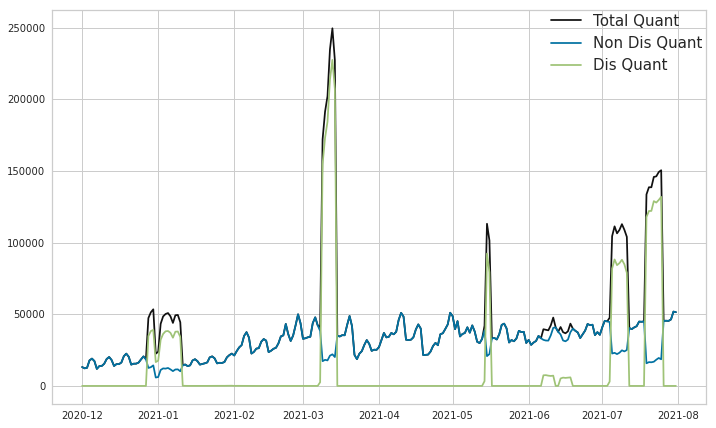

In [220]:
item_sales_perday(df_dig_offers_,2010)
print(2010,dict_name[2010])

Analyse BM

In [197]:
item = 2302

In [198]:
dig_offers = pd.read_excel("dig_offer_cal.xlsx")
dig_offers["Min date"] = pd.to_datetime(dig_offers["Min date"])
dig_offers["Max date"] = pd.to_datetime(dig_offers["Max date"])

In [199]:
dig_offers_ = dig_offers.loc[dig_offers.sld_menu_itm_id==item]

In [602]:
df_dig_offers_= pd.read_parquet(cfg['DIGITAL_OFFER_UNITS'].format(**cfg))

In [201]:
df_dig_offers_["sld_menu_itm_id"]=item

In [202]:
def get_units(x,col,item): #pos_itm_tot_qt,pos_itm_dsc_qt_up
    st = x["Min date"]
    ed = x["Max date"]
    return(df_dig_offers_.loc[(df_dig_offers_.sld_menu_itm_id==item)&(df_dig_offers_.pos_busn_dt>=st)&(df_dig_offers_.pos_busn_dt<=ed),col].sum())

In [203]:
dig_offers_ = dig_offers_[dig_offers_["Min date"]>="2021-02-15"]

In [204]:
df_dts = pd.DataFrame(pd.date_range("2021-03-01","2021-07-31",freq="W-MON")).rename(columns={0:"Max date"})
df_dts["Min date"] = df_dts["Max date"].shift(1)
df_dts.dropna(inplace=True)
df_dts["Max date"] = df_dts["Max date"] - pd.DateOffset(1)

In [206]:
dig_offers_all = dig_offers_.merge(df_dts,on=["Max date","Min date"],how="outer")

In [207]:
dig_offers_all["pos_itm_tot_qt_sum"]=dig_offers_all.apply(lambda x:get_units(x,"pos_itm_tot_qt"),axis=1)
dig_offers_all["pos_itm_dsc_qt_sum"]=dig_offers_all.apply(lambda x:get_units(x,"pos_itm_dsc_qt"),axis=1)
dig_offers_all["dsc/tot"] = dig_offers_all["pos_itm_dsc_qt_sum"]/dig_offers_all["pos_itm_tot_qt_sum"]

In [208]:
dig_offers_all.to_csv("cknb.csv")

## Regression Model

In [12]:
dig_offers = pd.read_excel("dig_offer_cal.xlsx")
df_dig_offers_= pd.read_parquet(cfg['DIGITAL_OFFER_UNITS'].format(**cfg))
df_base = pd.read_parquet("/opt/sasdata/dev/PricingEngines/DiscountEngines/Russia/data/processed/digital/base/")
#convert offer data into day level
df_promo_filtered_dup = dig_offers[["Min date","Max date"]].drop_duplicates()
df_promo_filtered_dup["pos_busn_dt"] =  df_promo_filtered_dup.apply(lambda x: pd.date_range(x["Min date"], x["Max date"]), axis=1)
df_promo_filtered_dup = df_promo_filtered_dup.explode("pos_busn_dt")
dig_offers = dig_offers.merge(df_promo_filtered_dup,on=["Min date","Max date"]).drop(columns=["Min date","Max date"])
dig_offers = dig_offers.merge(df_base[["pos_busn_dt","base_price","sld_menu_itm_id"]],on=["pos_busn_dt","sld_menu_itm_id"],how="left")
dig_offers["dsc_per"] = ((dig_offers.groupby(["offer_id","pos_busn_dt"]).offer_price.transform(sum)/dig_offers.groupby(["offer_id","pos_busn_dt"]).base_price.transform(sum))-1)
dig_offers["offer_price_avg"] =  -(dig_offers["base_price"]*dig_offers["dsc_per"])
dig_offers["Gift"] = dig_offers["public_name_en"].apply(lambda x:1 if "gift" in str(x) else 0)
dig_offers.drop(columns=["offer_price","base_price"],inplace=True)
dig_offers = dig_offers.drop_duplicates()

In [13]:
def get_units(x,col,item): #pos_itm_tot_qt,pos_itm_dsc_qt_up
    st = x["Min date"]
    ed = x["Max date"]
    return(df_dig_offers_.loc[(df_dig_offers_.sld_menu_itm_id==item)&(df_dig_offers_.pos_busn_dt>=st)&(df_dig_offers_.pos_busn_dt<=ed),col].sum())

In [75]:
item = 2100

In [76]:
df_wks = pd.DataFrame(pd.date_range("2021-03-01","2021-07-31",freq="W-MON")).rename(columns={0:"Max date"})
df_wks["Min date"] = df_wks["Max date"].shift(1)
df_wks.dropna(inplace=True)
df_wks["Max date"] = df_wks["Max date"] - pd.DateOffset(1)
df_wks["dsctotot"] = (df_wks.apply(lambda x:get_units(x,"pos_itm_dsc_qt",item),axis=1)/df_wks.apply(lambda x:get_units(x,"pos_itm_tot_qt",item),axis=1))
dig_offers = pd.read_excel("dig_offer_cal.xlsx")
dig_offers = dig_offers[dig_offers.sld_menu_itm_id==item]
dig_offers = dig_offers[dig_offers["Min date"]>="2021-02-01"]
dig_offers = dig_offers.groupby(["Min date","Max date"]).agg({"offer_id":"unique","Product Groupings":"unique","public_name_en":"unique","offer_price":"mean"}).reset_index()
df_wks = df_wks.merge(dig_offers,on=["Min date","Max date"],how="outer")

In [24]:
df_wks.to_csv("BM.csv")

In [669]:
def create_model_data(item):
    df_offer_item = dig_offers[dig_offers.sld_menu_itm_id==item]
    df_offer_item = pd.get_dummies(data=df_offer_item, columns=['Product Groupings', 'discount_dimension'])
    df_offer_item["offer_price_avg"]  = df_offer_item.groupby("pos_busn_dt").offer_price_avg.transform("mean")
    df_offer_item.drop(columns=["offer_id","sld_menu_itm_id","public_name_en","dsc_per"],inplace=True)
    df_offer_item = df_offer_item.groupby("pos_busn_dt").mean().reset_index()
    df_offer_item = df_offer_item[df_offer_item.pos_busn_dt>="2021-03-01"]
    df_wks = pd.DataFrame(pd.date_range("2021-03-01","2021-07-31",freq="W-MON")).rename(columns={0:"Max date"})
    df_wks["Min date"] = df_wks["Max date"].shift(1)
    df_wks.dropna(inplace=True)
    df_wks["Max date"] = df_wks["Max date"] - pd.DateOffset(1)
    df_wks["dsctotot"] = (df_wks.apply(lambda x:get_units(x,"pos_itm_dsc_qt",item),axis=1)/df_wks.apply(lambda x:get_units(x,"pos_itm_tot_qt",item),axis=1))
    df_wks = df_wks.reindex(columns=(df_wks.columns.tolist() + list(df_offer_item.columns[1:])))
    df_model = pd.DataFrame()
    for index, row in df_wks.iterrows():
        row.fillna(dict(df_offer_item[(df_offer_item.pos_busn_dt<=row['Max date'])&(df_offer_item.pos_busn_dt>=row['Min date'])].mean()),inplace=True)
        df_model = df_model.append(row,ignore_index=True)
    df_model.fillna(0,inplace=True)
    pg = [col for col in df_model.columns if "Groupings" in col]
    dd = [col for col in df_model.columns if "dimension" in col]
    for col in pg+dd:
        df_model.loc[df_model[col]>0,col]=1
    return df_model

In [573]:
from sklearn.linear_model import Lasso

In [676]:
df_model = create_model_data(2302)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [672]:
X, y = df_model.values[:, 3:], df_model.values[:, 2]
model = Lasso(alpha=0.01)
model.fit(X, y)
print(model.coef_)
print(model.intercept_)
print(df_model.columns[3:])

[-0.14238167 -0.02765669  0.         -0.          0.50154787  0.
  0.        ]
0.03409008901937649
Index(['Happy_Hrs', 'offer_price_avg', 'Gift', 'Product Groupings_Individual',
       'Product Groupings_Pair (1+1)',
       'discount_dimension_Price Discount - % Off',
       'discount_dimension_Price Discount - @Price Point'],
      dtype='object')


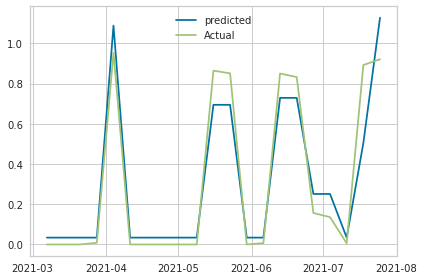

In [673]:
plt.plot(df_model["Max date"],model.predict(X),label = "predicted")
plt.plot(df_model["Max date"],y,label = "Actual")
plt.legend()
plt.show()

In [679]:
df_model = create_model_data(2100)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [680]:
X, y = df_model.values[:, 3:], df_model.values[:, 2]
model = Lasso(alpha=0.001)
model.fit(X, y)
print(model.coef_)
print(model.intercept_)
print(df_model.columns[3:])

[-3.33557908e-01  5.38982138e-04  3.21860661e-01  2.45361511e-01
  1.24963498e-01  0.00000000e+00 -1.30520748e-02  5.64143205e-01
  5.04525819e-01]
0.005804019596975796
Index(['Happy_Hrs', 'offer_price_avg', 'Gift', 'Product Groupings_Individual',
       'Product Groupings_Pair (1+1)', 'Product Groupings_Set  - 2 products',
       'Product Groupings_Set  - 3 products (Inclusive of Toy)',
       'discount_dimension_Price Discount - % Off',
       'discount_dimension_Price Discount - @Price Point'],
      dtype='object')


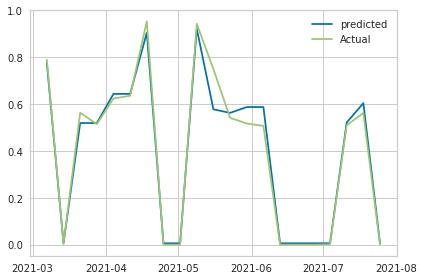

In [681]:
plt.plot(df_model["Max date"],model.predict(X),label = "predicted")
plt.plot(df_model["Max date"],y,label = "Actual")
plt.legend()
plt.show()

In [694]:
df_model = create_model_data(2010)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [695]:
X, y = df_model.values[:, 3:], df_model.values[:, 2]
model = Lasso(alpha=0.001)
model.fit(X, y)
print(model.coef_)
print(model.intercept_)
print(df_model.columns[3:])
#talib.regresion.sks.stat ols stats

[-0.35317339  0.03383663  0.         -0.          0.4647087   0.03510014
 -0.28149338]
0.0033779431098988344
Index(['Happy_Hrs', 'offer_price_avg', 'Gift', 'Product Groupings_Individual',
       'Product Groupings_Pair (1+1)',
       'discount_dimension_Price Discount - % Off',
       'discount_dimension_Price Discount - @Price Point'],
      dtype='object')


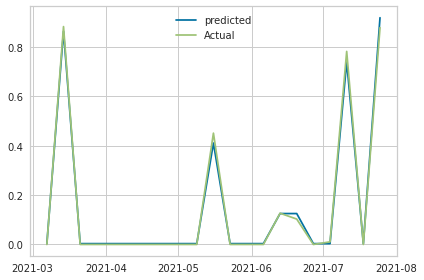

In [696]:
plt.plot(df_model["Max date"],model.predict(X),label = "predicted")
plt.plot(df_model["Max date"],y,label = "Actual")
plt.legend()
plt.show()

In [638]:
df_model.columns

Index(['Max date', 'Min date', 'dsctotot', 'Happy_Hrs', 'offer_price_avg',
       'Gift', 'Product Groupings_Individual', 'Product Groupings_Pair (1+1)',
       'discount_dimension_Price Discount - % Off',
       'discount_dimension_Price Discount - @Price Point'],
      dtype='object')

In [678]:
df_model['dsctotot'].corr(df_model['offer_price_avg'])

0.7435894524444511

## day level models

In [75]:
dig_offers = pd.read_excel("dig_offer_cal.xlsx")
df_dig_offers_= pd.read_parquet(cfg['DIGITAL_OFFER_UNITS'].format(**cfg))
df_base = pd.read_parquet("/opt/sasdata/dev/PricingEngines/DiscountEngines/Russia/data/processed/digital/base/")
#convert offer data into day level
df_promo_filtered_dup = dig_offers[["Min date","Max date"]].drop_duplicates()
df_promo_filtered_dup["pos_busn_dt"] =  df_promo_filtered_dup.apply(lambda x: pd.date_range(x["Min date"], x["Max date"]), axis=1)
df_promo_filtered_dup = df_promo_filtered_dup.explode("pos_busn_dt")
dig_offers = dig_offers.merge(df_promo_filtered_dup,on=["Min date","Max date"]).drop(columns=["Min date","Max date"])
dig_offers = dig_offers.merge(df_base[["pos_busn_dt","base_price","sld_menu_itm_id"]],on=["pos_busn_dt","sld_menu_itm_id"],how="left")
dig_offers["dsc_per"] = ((dig_offers.groupby(["offer_id","pos_busn_dt"]).offer_price.transform(sum)/dig_offers.groupby(["offer_id","pos_busn_dt"]).base_price.transform(sum))-1)
dig_offers["offer_price_per"] =  -(dig_offers["dsc_per"])
dig_offers["Gift"] = dig_offers["public_name_en"].apply(lambda x:1 if "gift" in str(x) else 0)
dig_offers.drop(columns=["offer_price","base_price"],inplace=True)
dig_offers = dig_offers.drop_duplicates()

In [76]:
def get_model_data_daily(item,non_dis=False):
    df_offer_item = dig_offers[dig_offers.sld_menu_itm_id==item]
    df_offer_units = df_dig_offers_[df_dig_offers_.sld_menu_itm_id==item][["pos_busn_dt","pos_itm_dsc_qt","pos_itm_tot_qt"]]
    df_offer_units["per_dsc_units"] = df_offer_units["pos_itm_dsc_qt"]/df_offer_units["pos_itm_tot_qt"]
    df_offer_item = pd.get_dummies(data=df_offer_item, columns=['Product Groupings', 'discount_dimension'])
    df_offer_item.drop(columns=["offer_id","sld_menu_itm_id","public_name_en","dsc_per"],inplace=True)
    df_offer_item = df_offer_item[df_offer_item.pos_busn_dt>="2021-03-01"]
    df_daily = pd.DataFrame(pd.date_range("2021-03-01","2021-07-31")).rename(columns={0:"pos_busn_dt"})
    df_daily = df_daily.merge(df_offer_item,on="pos_busn_dt",how="left")
#     df_daily.drop(columns=["offer_price_per"],inplace=True)
    df_daily.fillna(0,inplace=True)
    df_daily = df_daily.groupby("pos_busn_dt").sum().reset_index()
    df_daily = df_daily.merge(df_offer_units[["pos_busn_dt","per_dsc_units"]],on="pos_busn_dt",how="left")
    pg = [col for col in df_daily.columns if "Groupings" in col]
    dd = [col for col in df_daily.columns if "dimension" in col]
#     df_daily.drop(columns=["Weekend"],inplace=True)
    for col in pg+dd:
        df_daily.loc[df_daily[col]>0,col]=1
    if non_dis:
        df_daily.loc[df_daily[pg+dd].sum(axis=1)==0,"per_dsc_units"]=0
    return df_daily

In [197]:
def compute_mape(df_model__,item,yhat):
    df_model__["per_dsc_units_pred"] = yhat 
    df_model__ = df_model__.merge(df_dig_offers_[df_dig_offers_.sld_menu_itm_id==item][["pos_busn_dt","pos_itm_dsc_qt","pos_itm_tot_qt","pos_itm_non_dsc_amt","pos_itm_dsc_amt"]],on="pos_busn_dt",how="left")
    df_model__["pos_itm_dsc_qt_pred"] = df_model__["pos_itm_tot_qt"]*df_model__["per_dsc_units_pred"]
    pg = [col for col in df_model__.columns if "Groupings" in col]
    dd = [col for col in df_model__.columns if "dimension" in col]
    df_model_ = df_model__.loc[df_model__[pg+dd].sum(axis=1)>0,:]
    print("Actual units: ",df_model_.pos_itm_dsc_qt.mean())
    print("Pred units: ",df_model_.pos_itm_dsc_qt_pred.mean())
    mape_units = np.mean(np.abs(
        (df_model_["pos_itm_dsc_qt"] -df_model_["pos_itm_dsc_qt_pred"]) / (df_model_["pos_itm_dsc_qt"])
    )) * 100
    return mape_units,df_model__

In [198]:
def get_model_data_daily_dd_inter(item):
    df_offer_item = dig_offers[dig_offers.sld_menu_itm_id==item]
    df_offer_units = df_dig_offers_[df_dig_offers_.sld_menu_itm_id==item][["pos_busn_dt","pos_itm_dsc_qt","pos_itm_tot_qt"]]
    df_offer_units["per_dsc_units"] = df_offer_units["pos_itm_dsc_qt"]/df_offer_units["pos_itm_tot_qt"]
    df_offer_item["discount_dimension"] =df_offer_item["discount_dimension"]+df_offer_item["Product Groupings"]
    df_offer_item = pd.get_dummies(data=df_offer_item, columns=['Product Groupings', 'discount_dimension'])
    df_offer_item.drop(columns=["offer_id","sld_menu_itm_id","public_name_en","dsc_per"],inplace=True)
    df_offer_item = df_offer_item[df_offer_item.pos_busn_dt>="2021-03-01"]
    df_daily = pd.DataFrame(pd.date_range("2021-03-01","2021-07-31")).rename(columns={0:"pos_busn_dt"})
    df_daily = df_daily.merge(df_offer_item,on="pos_busn_dt",how="left")
    
    df_daily = df_daily.groupby("pos_busn_dt").sum().reset_index()
    df_daily = df_daily.merge(df_offer_units[["pos_busn_dt","per_dsc_units"]],on="pos_busn_dt",how="left")
    pg = [col for col in df_daily.columns if "Groupings" in col]
    dd = [col for col in df_daily.columns if "dimension" in col]
    df_daily.drop(columns=["offer_price_per"],inplace=True)
    for col in pg+dd:
        df_daily.loc[df_daily[col]>0,col]=1
    df_daily.fillna(0,inplace=True)
    return df_daily

In [219]:
df_model = get_model_data_daily_dd_inter(4065)
s=df_model.sum()
df_model.drop(columns=(s[s==0]).index,inplace=True)
# X_train,y_train = (df_model.iloc[:,1:-1],df_model.iloc[:,-1])
# model = SKLStatsmodelOLS(fit_intercept=False)
# model.fit(X_train,y_train)

In [220]:
df_model

,pos_busn_dt
0,2021-03-01
1,2021-03-02
2,2021-03-03
3,2021-03-04
4,2021-03-05
...,...
148,2021-07-27
149,2021-07-28
150,2021-07-29
151,2021-07-30


In [200]:
def plot_datat(item):
    df_model = get_model_data_daily_dd_inter(item)
    s=df_model.sum()
    df_model.drop(columns=(s[s==0]).index,inplace=True)
    X_train,y_train = (df_model.iloc[:,1:-1],df_model.iloc[:,-1])
    model = SKLStatsmodelOLS(fit_intercept=False)
    model.fit(X_train,y_train)
    fig, ax = plt.subplots()
    plt.plot(df_model.pos_busn_dt,model.predict(X_train),label = "predicted")
    plt.plot(df_model.pos_busn_dt,y_train,label = "Actual")
    plt.legend()
    print("Mape:",compute_mape(df_model,item,model.predict(X_train))[0])
    return plt,compute_mape(df_model,item,model.predict(X_train))[1]

Actual units:  77619.51351351352
Pred units:  74222.8298809856
Mape: 45.92932088395618
Actual units:  77619.51351351352
Pred units:  74222.8298809856
Actual units:  2302.75
Pred units:  2301.257917825168
Mape: 8.90881838916446
Actual units:  2302.75
Pred units:  2301.257917825168
Actual units:  26515.186813186814
Pred units:  25729.262704592496
Mape: 14.797064793359754
Actual units:  26515.186813186814
Pred units:  25729.262704592496
Actual units:  5509.823529411765
Pred units:  5491.471522570444
Mape: 9.4942195750211
Actual units:  5509.823529411765
Pred units:  5491.471522570444
Actual units:  82744.12698412698
Pred units:  78706.72748931852
Mape: 53.11212518014153
Actual units:  82744.12698412698
Pred units:  78706.72748931852
Actual units:  4958.009523809524
Pred units:  4733.9141976296805
Mape: 409.72064081949594
Actual units:  4958.009523809524
Pred units:  4733.9141976296805
Actual units:  3108.8653846153848
Pred units:  2950.6972484377684
Mape: 49.72463501171725
Actual units:  

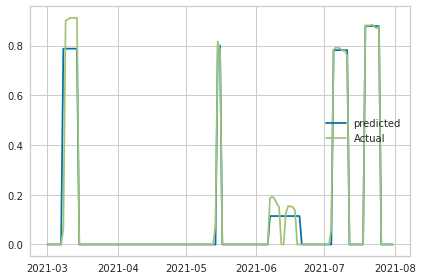

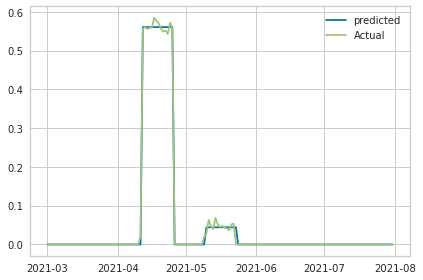

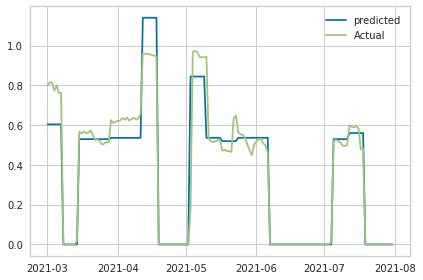

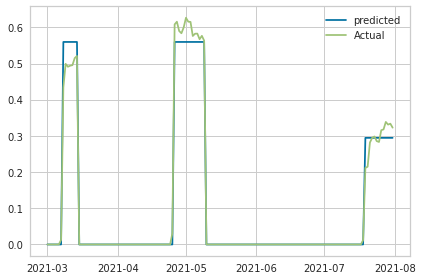

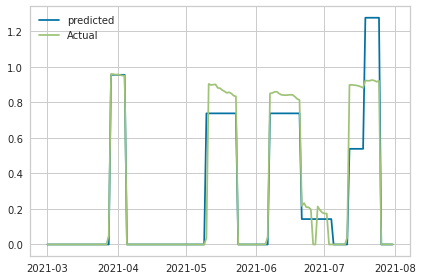

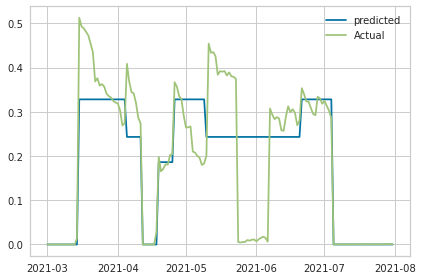

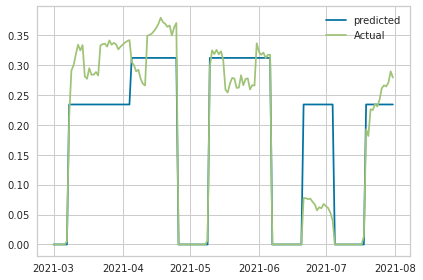

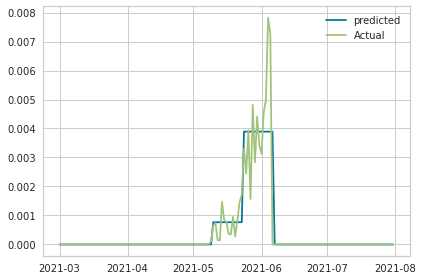

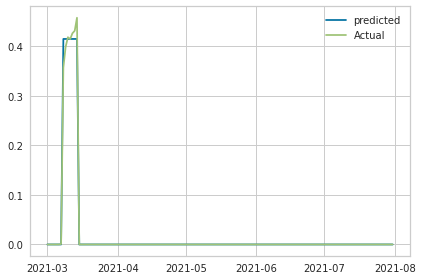

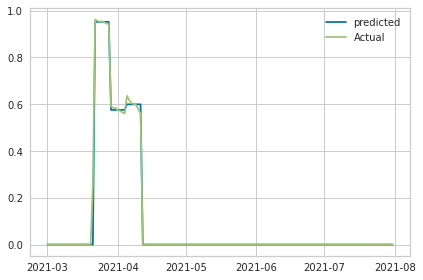

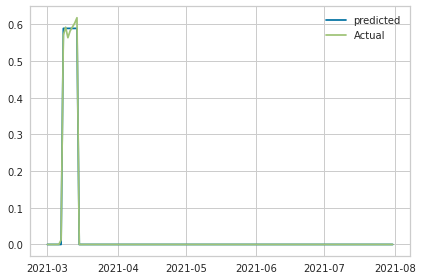

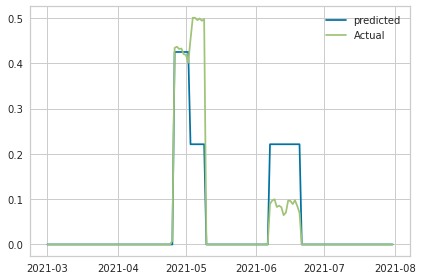

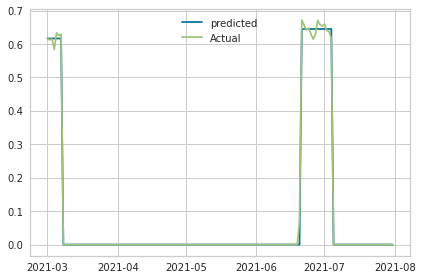

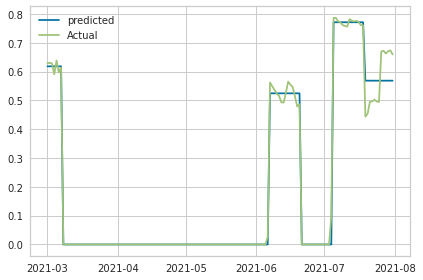

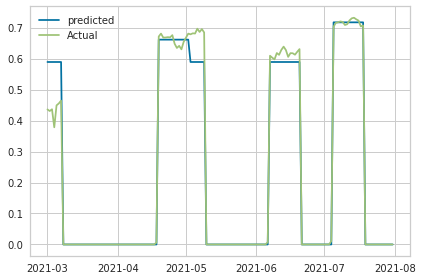

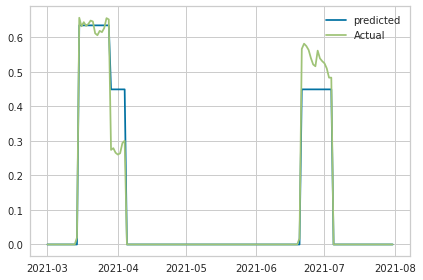

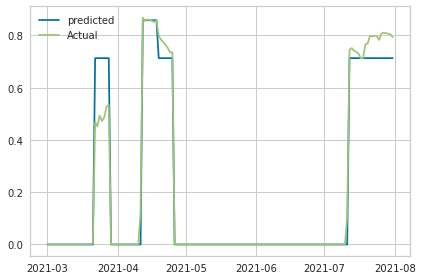

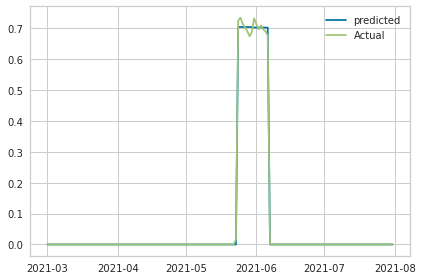

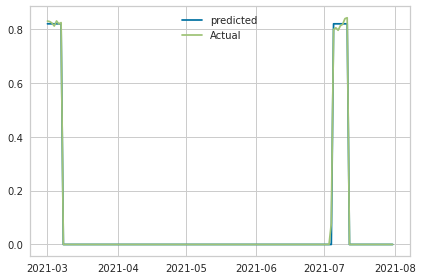

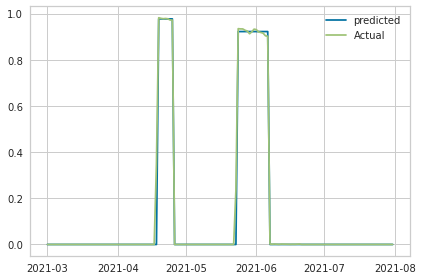

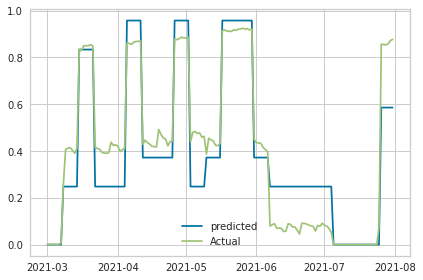

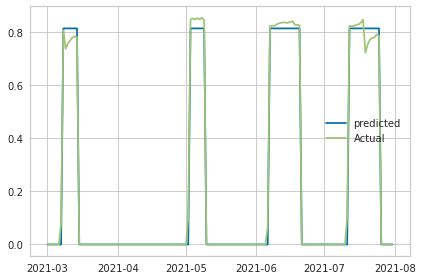

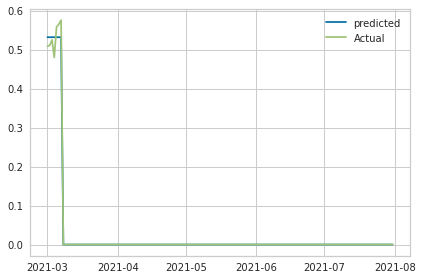

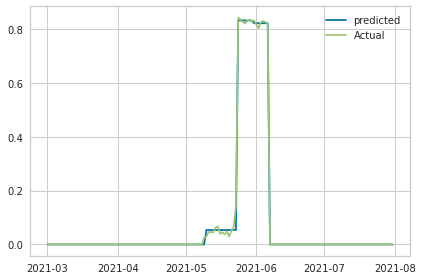

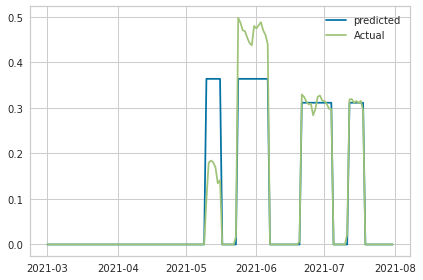

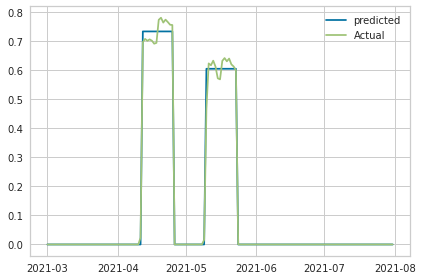

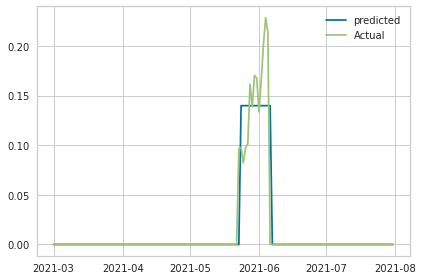

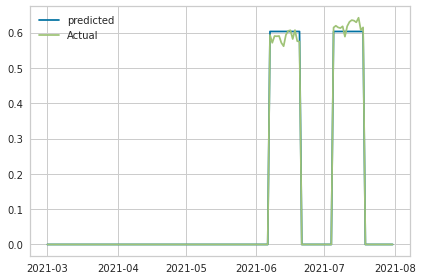

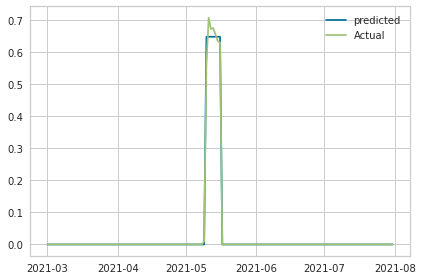

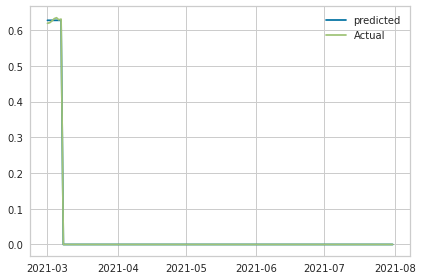

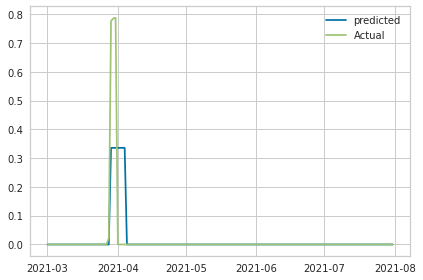

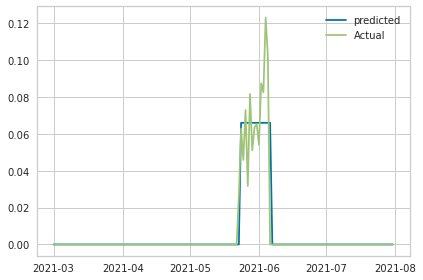

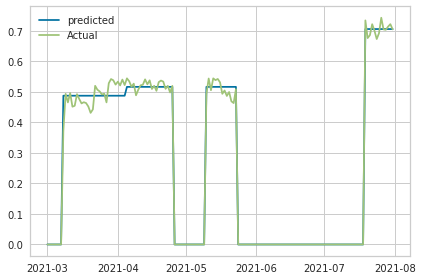

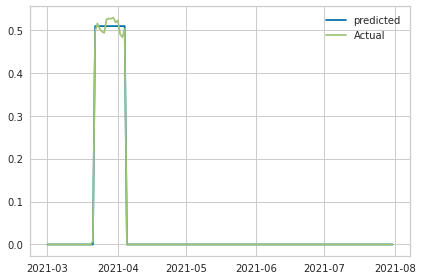

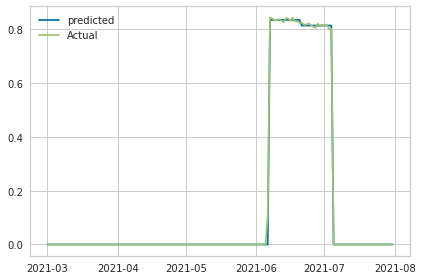

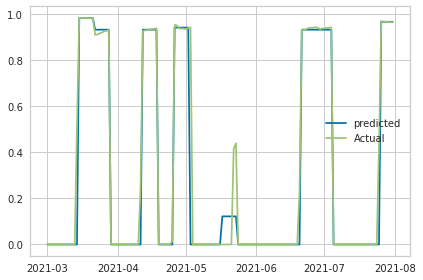

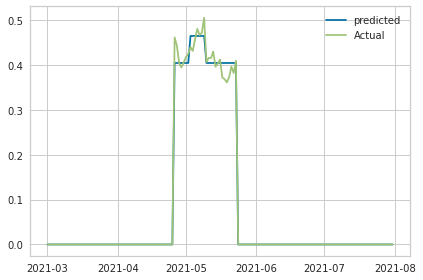

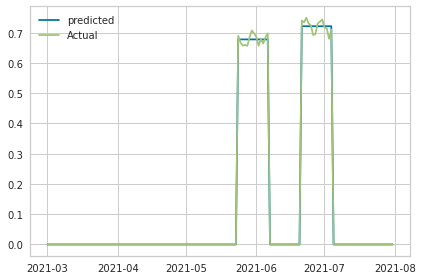

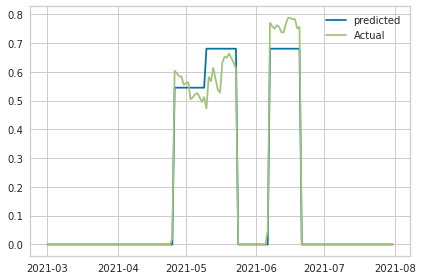

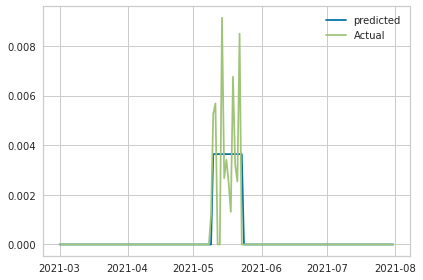

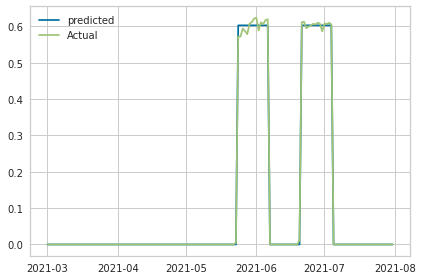

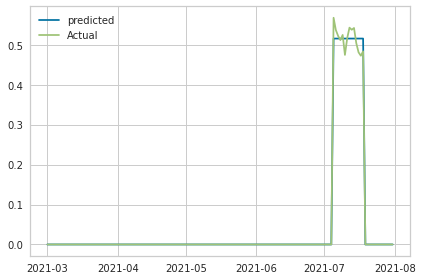

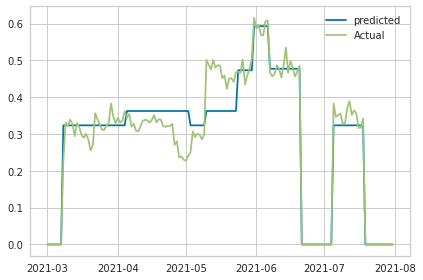

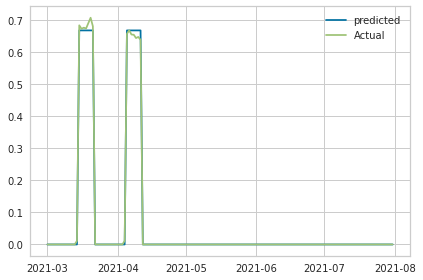

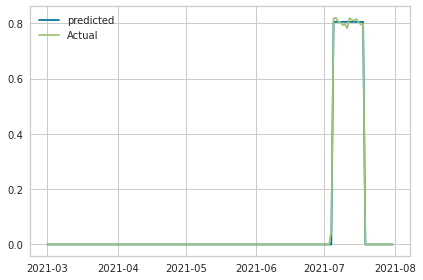

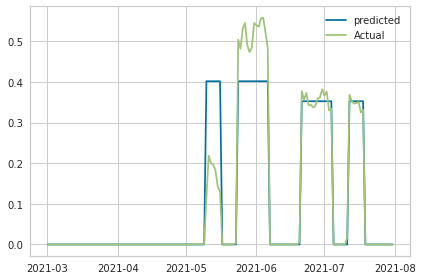

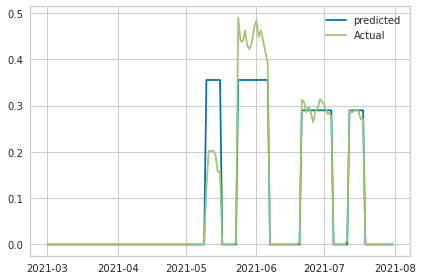

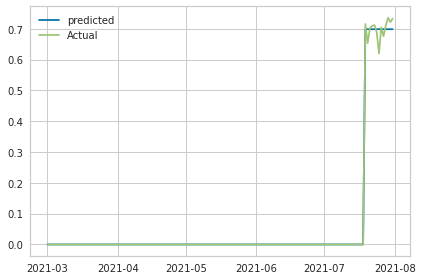

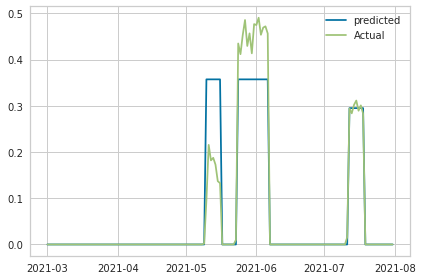

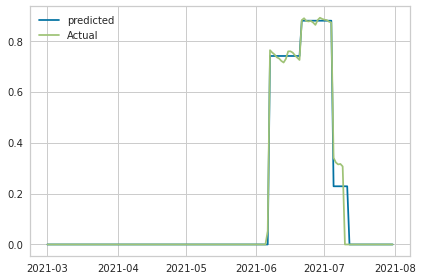

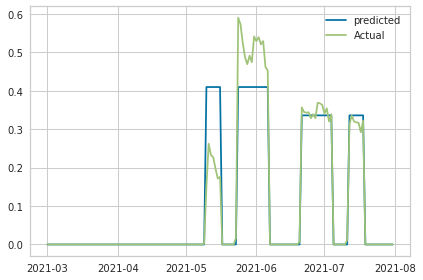

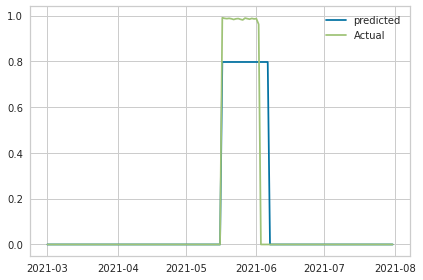

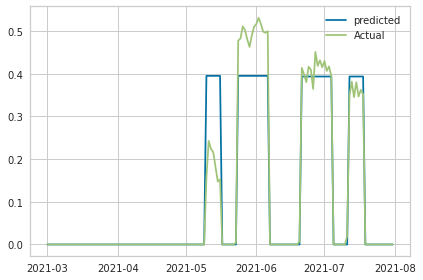

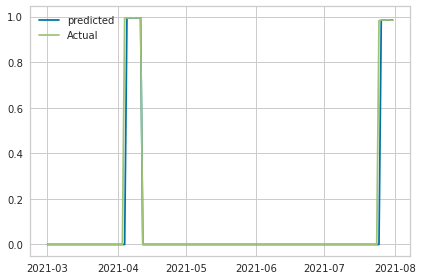

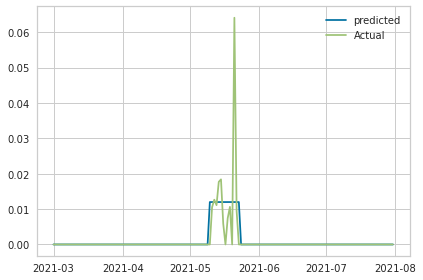

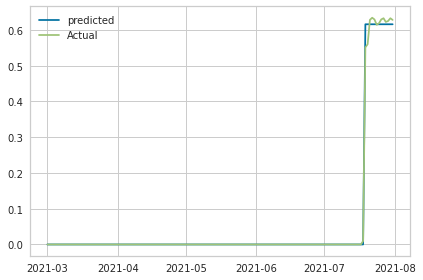

In [221]:
# item = list(df_top["sld_menu_itm_id"])[6]#2,4,# 5,6,11something wrong
df_item_all = pd.DataFrame()
for item in list(df_top["sld_menu_itm_id"]):
    try:
        df_item = (plot_datat(item)[1])
        df_item["sld_menu_itm_id"]=item
        df_item_all = df_item_all.append(df_item)
    except:
        print(item)

In [222]:
df_item_all.to_csv("top_items.csv")

In [213]:
df_model = get_model_data_daily_dd_inter(item)

In [214]:
df_t = df_dig_offers_[df_dig_offers_.sld_menu_itm_id==item]

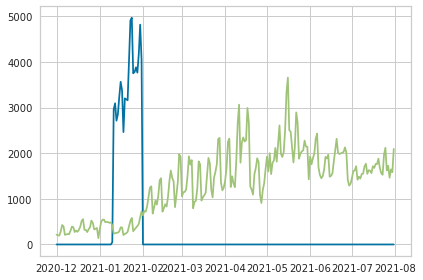

In [215]:
# plt.plot(df_t["pos_busn_dt"],df_t["pos_itm_tot_qt"])
plt.plot(df_t["pos_busn_dt"],df_t["pos_itm_dsc_qt"])
plt.plot(df_t["pos_busn_dt"],df_t["pos_itm_non_qt"])

In [71]:
df_item_master = pd.read_csv(cfg["ITEM_MASTER"].format(**cfg))

In [72]:
df_top = df_item_master.loc[(df_item_master.Included_in_Model==1)&(df_item_master.sld_menu_itm_id.isin(items)),:].reset_index().sort_values(by="revenue_annual",ascending=False).loc[:20,["sld_menu_itm_id","Name"]]
dict_items = dict(zip(df_top["sld_menu_itm_id"],df_top["Name"]))

In [74]:
item

2010

In [143]:
def create_tabs(func,dict_info):
    sub_tab=[widgets.Output() for i in range(len(dict_info))]
    tab = widgets.Tab(sub_tab)
    widgets.Output(layout={'border': '1px solid black', 'overflow': 'scroll', 'display': 'flex',})
    i=0
    for item in dict_info:
        tab.set_title(i,dict_items[item])
        with sub_tab[i]:
            plt.show(func(item))
        i+=1
    display(tab)

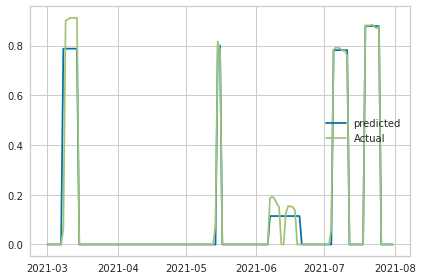

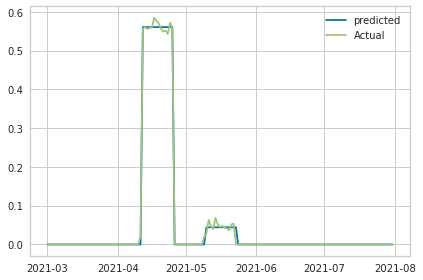

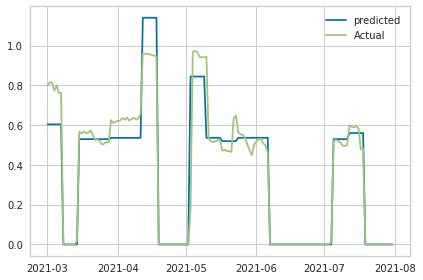

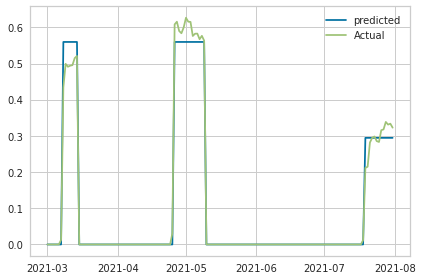

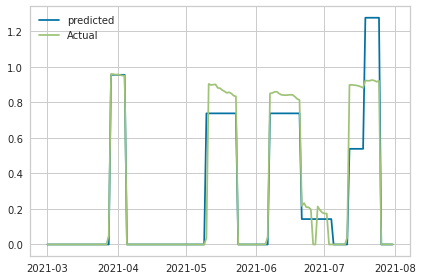

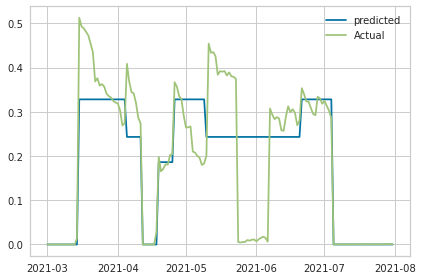

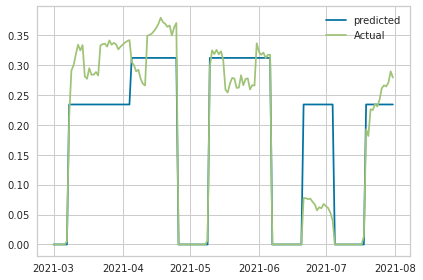

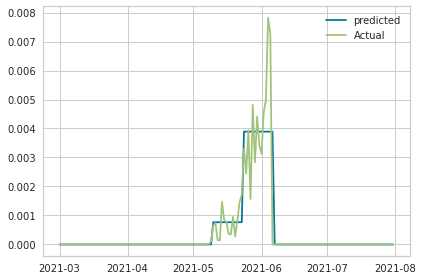

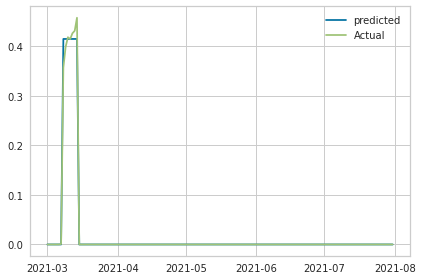

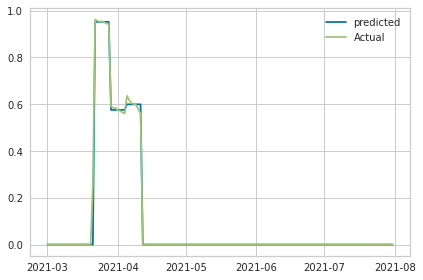

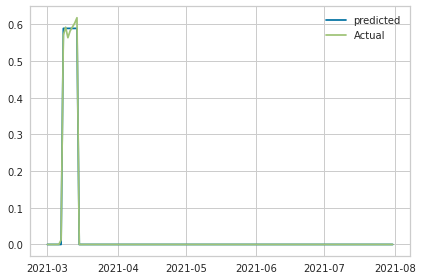

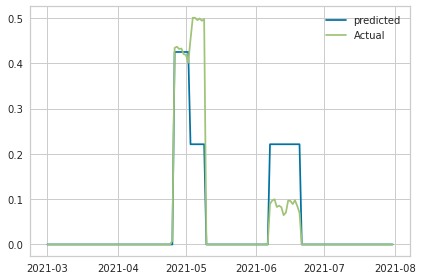

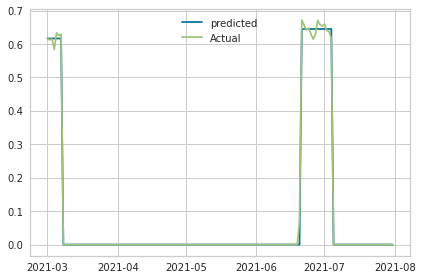

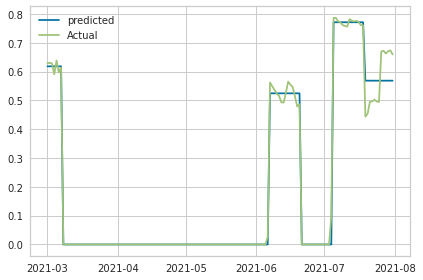

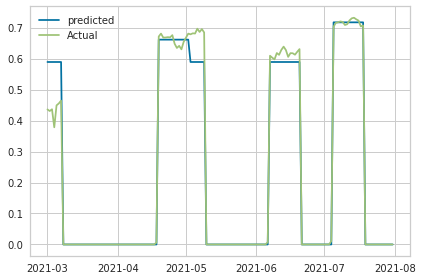

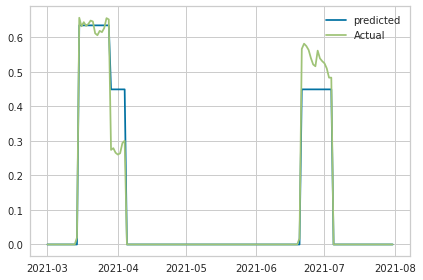

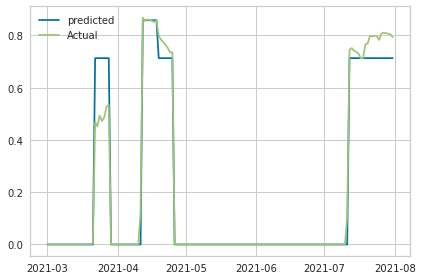

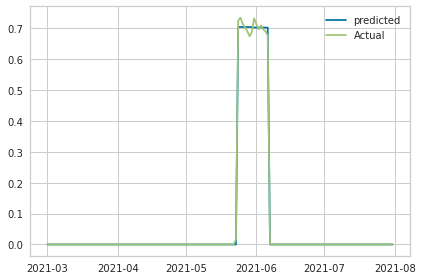

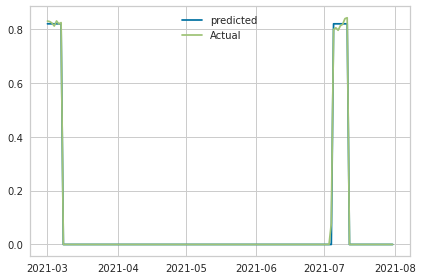

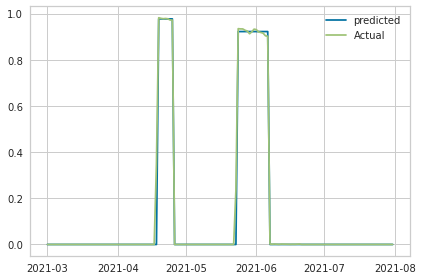

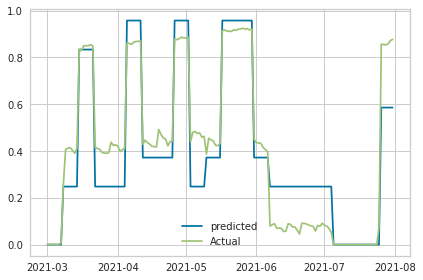

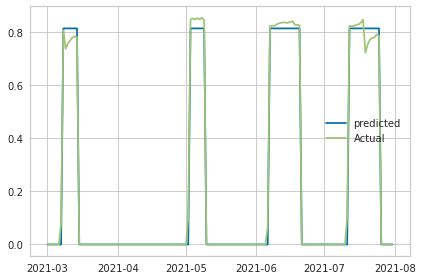

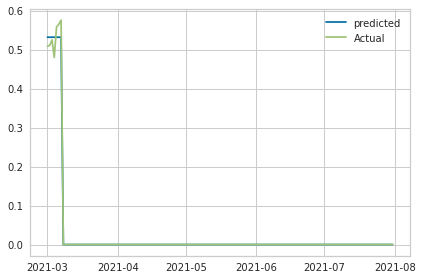

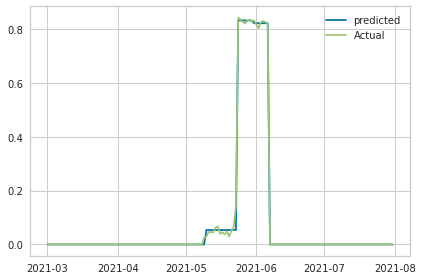

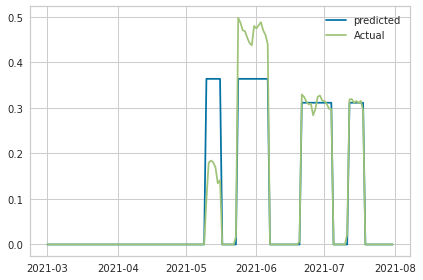

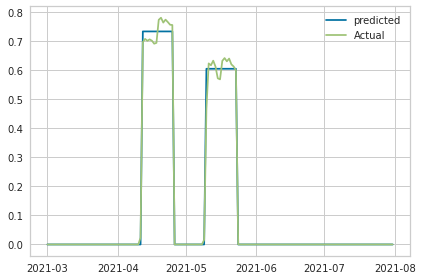

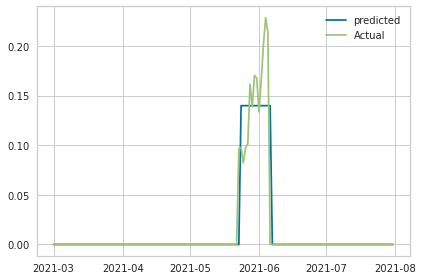

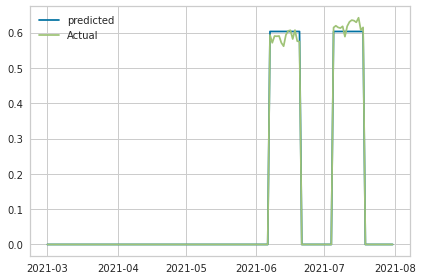

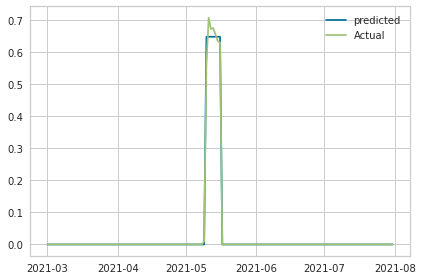

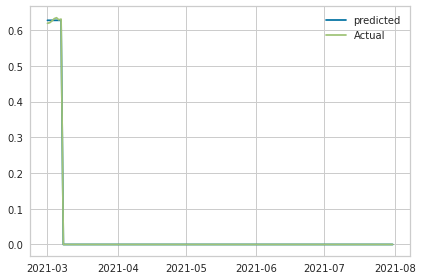

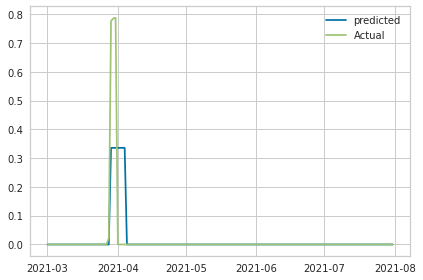

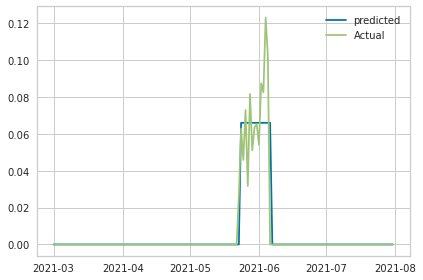

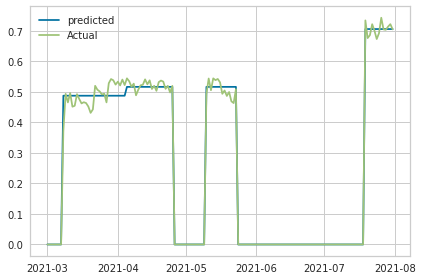

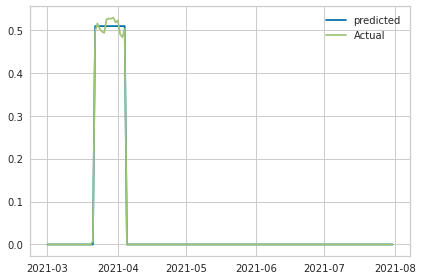

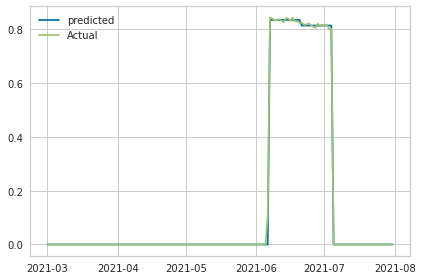

ValueError: at least one array or dtype is required

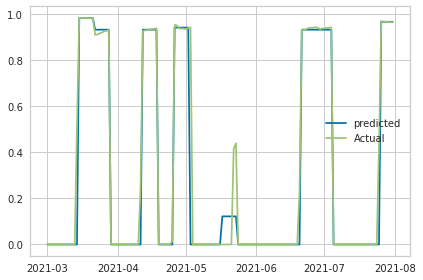

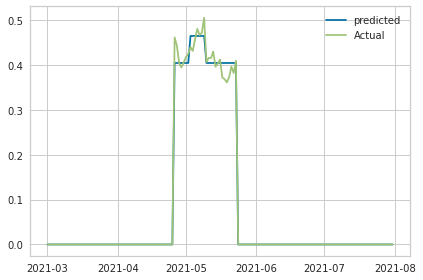

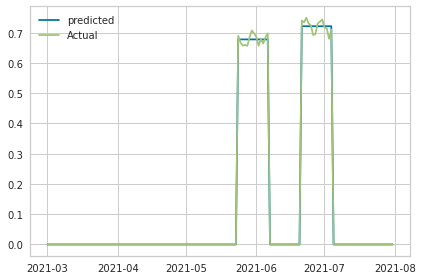

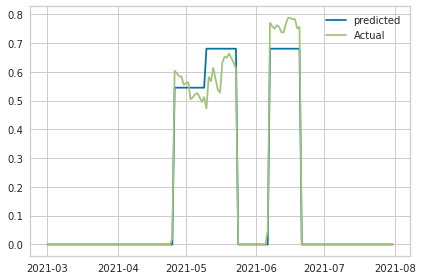

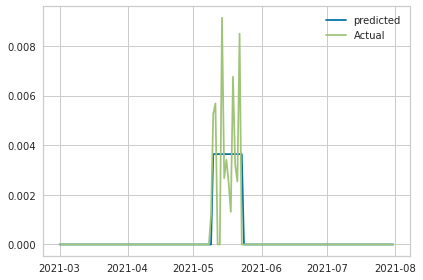

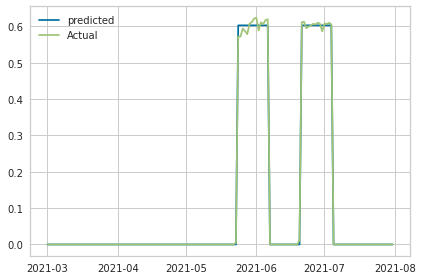

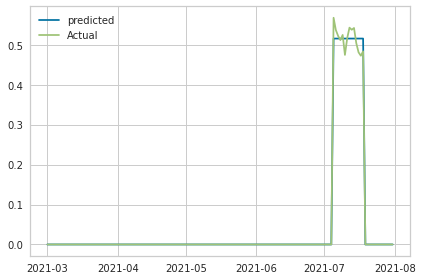

ValueError: at least one array or dtype is required

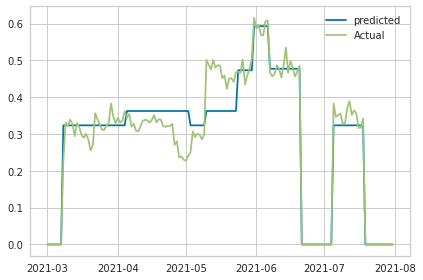

ValueError: at least one array or dtype is required

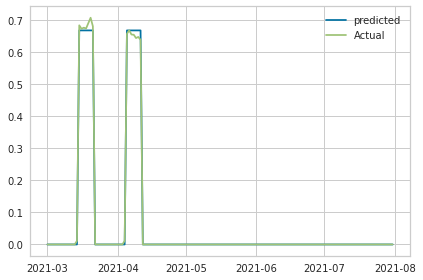

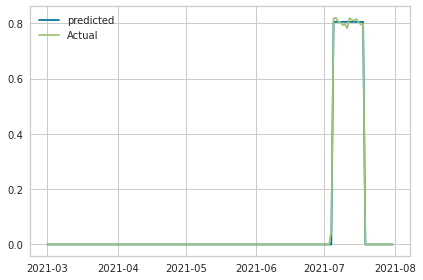

ValueError: at least one array or dtype is required

ValueError: at least one array or dtype is required

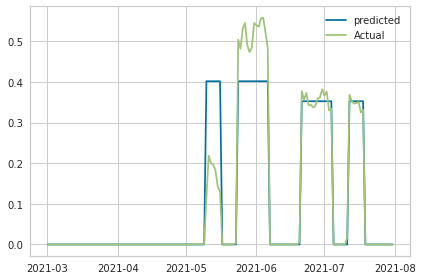

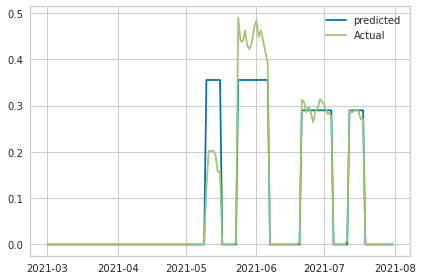

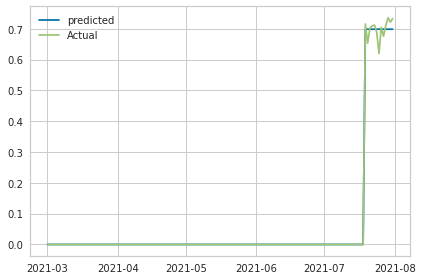

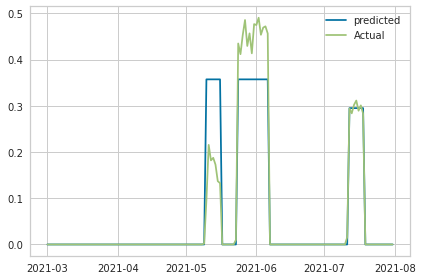

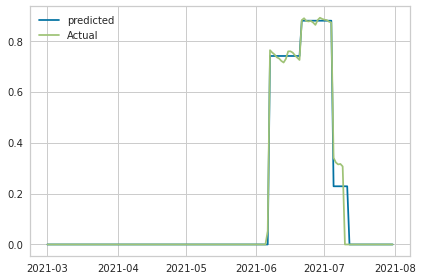

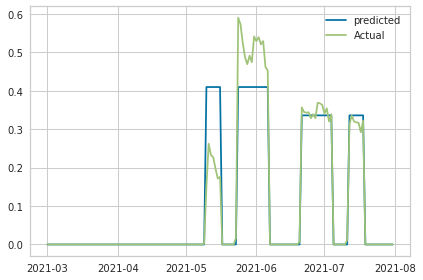

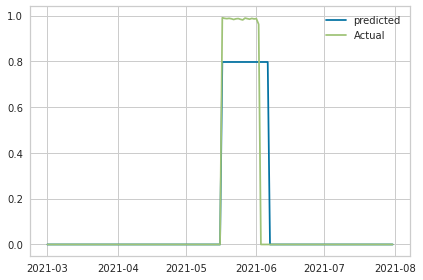

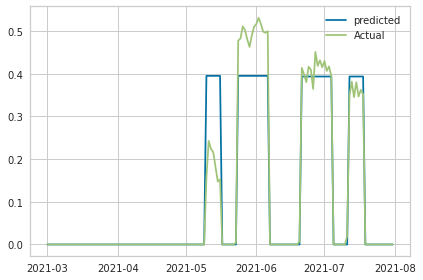

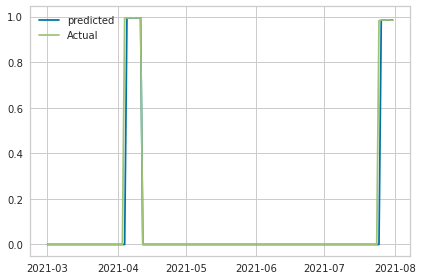

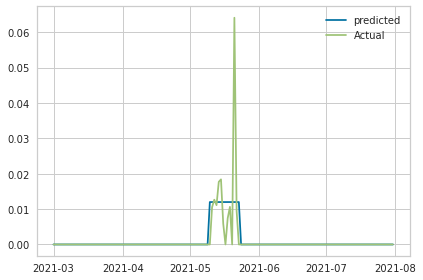

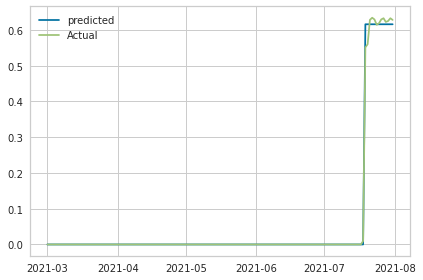

In [144]:
create_tabs(plot_datat,df_top["sld_menu_itm_id"])

In [199]:
pd.DataFrame(model.coeff_table(add_vif=False))

,coef,std err,t,P>|t|,[0.025,0.975]
Happy_Hrs,-0.0505,0.016,-3.066,0.003,-0.083,-0.018
Product Groupings_Individual,0.2438,0.017,14.351,0.000,0.210,0.277
Product Groupings_Pair (1+1),0.3847,0.024,15.850,0.000,0.337,0.433
discount_dimension_Price Discount - % OffIndividual,0.2943,0.024,12.186,0.000,0.247,0.342
discount_dimension_Price Discount - % OffPair (1+1),0.0318,0.042,0.756,0.451,-0.051,0.115
discount_dimension_Price Discount - @Price PointIndividual,-0.0505,0.016,-3.066,0.003,-0.083,-0.018
discount_dimension_Price Discount - @Price PointPair (1+1),0.3529,0.024,14.541,0.000,0.305,0.401


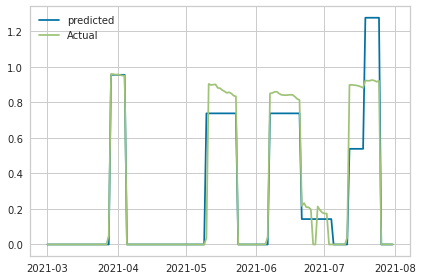

In [201]:
plt.plot(df_model.pos_busn_dt,model.predict(X_train),label = "predicted")
plt.plot(df_model.pos_busn_dt,y_train,label = "Actual")
plt.legend()
plt.show()

## Include discount depth

In [646]:
df_depth = pd.read_csv("discount_depth_digital.csv")
df_depth = df_depth.groupby(["pos_busn_dt","sld_menu_itm_id"])["value"].mean().reset_index()
df_depth["pos_busn_dt"] = pd.to_datetime(df_depth["pos_busn_dt"])
df_depth.rename(columns={"value":"avg_depth"},inplace=True)
scaler = MinMaxScaler()
# df_depth["avg_depth"] = scaler.fit_transform(df_depth["avg_depth"])

In [722]:
def get_model_data_daily_depth(item):
    df_offer_item  = dig_offers[dig_offers.sld_menu_itm_id==item]
    df_offer_units = df_dig_offers_[df_dig_offers_.sld_menu_itm_id==item][["pos_busn_dt","pos_itm_dsc_qt","pos_itm_tot_qt"]]
    df_depth_item  = df_depth[df_depth.sld_menu_itm_id==item]
    df_offer_units["per_dsc_units"] = df_offer_units["pos_itm_dsc_qt"]/df_offer_units["pos_itm_tot_qt"]
    df_offer_item = pd.get_dummies(data=df_offer_item, columns=['Product Groupings', 'discount_dimension'])
    df_offer_item.drop(columns=["offer_id","sld_menu_itm_id","public_name_en","dsc_per"],inplace=True)
    df_offer_item = df_offer_item[df_offer_item.pos_busn_dt>="2021-03-01"]
    df_daily = pd.DataFrame(pd.date_range("2021-03-01","2021-07-31")).rename(columns={0:"pos_busn_dt"})
    df_daily = df_daily.merge(df_offer_item,on="pos_busn_dt",how="left")
#     df_daily.drop(columns=["offer_price_avg"],inplace=True)
    df_daily.fillna(0,inplace=True)
    df_daily = df_daily.groupby("pos_busn_dt").mean().reset_index()
#     df_daily = df_daily.merge(df_depth_item[["pos_busn_dt","avg_depth"]],on="pos_busn_dt",how="left")
    df_daily.fillna(0,inplace=True)
#     df_daily["avg_depth"]=(df_daily["avg_depth"]-df_daily["avg_depth"].min())/(df_daily["avg_depth"].max()-df_daily["avg_depth"].min())
    df_daily = df_daily.merge(df_offer_units[["pos_busn_dt","per_dsc_units"]],on="pos_busn_dt",how="left")
    pg = [col for col in df_daily.columns if "Groupings" in col]
    dd = [col for col in df_daily.columns if "dimension" in col]
    for col in pg+dd:
        df_daily.loc[df_daily[col]>0,col]=1
    return df_daily

In [723]:
df_model = get_model_data_daily_depth(2010)
s=df_model.sum()
df_model.drop(columns=(s[s==0]).index,inplace=True)
pg = [col for col in df_model.columns if "Groupings" in col]
dd = [col for col in df_model.columns if "dimension" in col]
df_model.drop(columns=dd,inplace=True)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [724]:
X_train,y_train = (df_model.iloc[:,1:-1],df_model.iloc[:,-1])
model = SKLStatsmodelOLS(fit_intercept=True)
model.fit(X_train,y_train)

SKLStatsmodelOLS()

In [725]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     221.4
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           1.52e-66
Time:                        10:25:11   Log-Likelihood:                 132.95
No. Observations:                 153   AIC:                            -253.9
Df Residuals:                     147   BIC:                            -235.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
intercept                        0.0006      0.010      0.059      0.953      -0.019       0.020
Happy_Hrs                        0.2268      0.115      1.976      0.050    1.04e-05       0.454
Weekend                          0.5836      0.249      2.342      0.021       0.091       1.076
offer_price_per                  7.7190      4.704      1.641      0.103      -1.577      17.015
Product Groupings_Individual    -2.0428      1.277     -1.600      0.112      -4.566       0.481
Product Groupings_Pair (1+1)    -0.2579      0.635     -0.406      0.685      -1.512       0.996
==============================================================================
Omnibus:                       68.915   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4676.301
Skew:                          -0.514   Prob(JB):                         0.00
Kurtosis:                      30.064   Cond. No.                         620.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

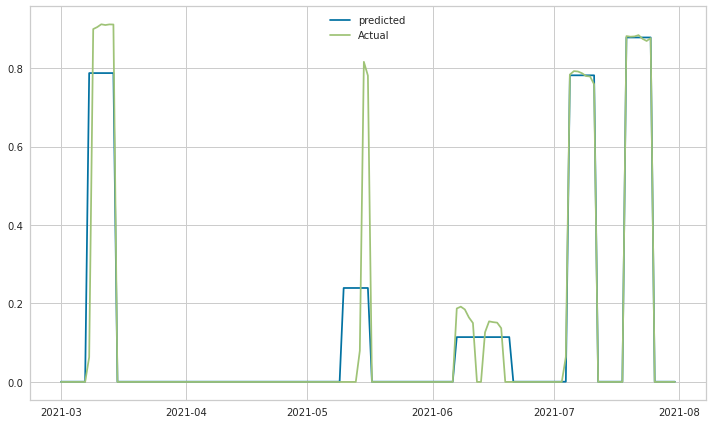

In [726]:
plt.plot(df_model.pos_busn_dt,model.predict(X_train),label = "predicted")
plt.plot(df_model.pos_busn_dt,y_train,label = "Actual")
plt.legend()
plt.show()

In [783]:
X, y = df_model.iloc[:,1:-1].values, df_model.iloc[:,-1].values
model = Lasso(alpha=0.001)
model.fit(X, y)
print(model.coef_)
print(model.intercept_)
print(df_model.columns)
# model.summary()
#talib.regresion.sks.stat ols stats

[-0.50356876 -0.12248037  0.56069323  0.51122658  0.49657761 -0.        ]
0.028093799919405804
Index(['pos_busn_dt', 'Happy_Hrs', 'Gift', 'Product Groupings_Individual',
       'Product Groupings_Pair (1+1)', 'Product Groupings_Set  - 2 products',
       'Product Groupings_Set  - 3 products (Inclusive of Toy)',
       'per_dsc_units'],
      dtype='object')


In [731]:
(30/50)-1

-0.4

In [786]:
df_model[df_model['pos_busn_dt']>="2021-05-09"]#07-19

,pos_busn_dt,Happy_Hrs,Gift,Product Groupings_Individual,Product Groupings_Pair (1+1),Product Groupings_Set - 2 products,Product Groupings_Set - 3 products (Inclusive of Toy),per_dsc_units
69,2021-05-09,0.0,2.0,1.0,1.0,0.0,0.0,0.939780
70,2021-05-10,0.0,0.0,0.0,0.0,1.0,0.0,0.944401
71,2021-05-11,0.0,0.0,0.0,0.0,1.0,0.0,0.532246
72,2021-05-12,0.0,0.0,0.0,0.0,1.0,0.0,0.517942
73,2021-05-13,0.0,0.0,0.0,0.0,1.0,0.0,0.514926
...,...,...,...,...,...,...,...,...
148,2021-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
149,2021-07-28,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
150,2021-07-29,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
151,2021-07-30,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
df_base = pd.read_parquet("/opt/sasdata/dev/PricingEngines/DiscountEngines/Russia/data/processed/offline/base/")

In [162]:
X_train,y_train = (df_model.drop(columns="offer_price_per").iloc[:,1:-1],df_model.iloc[:,-1])

In [174]:
y_train_new = (y_train-y_train.min())/(y_train.max())

In [179]:
binom_glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
binom_results = binom_glm.fit()

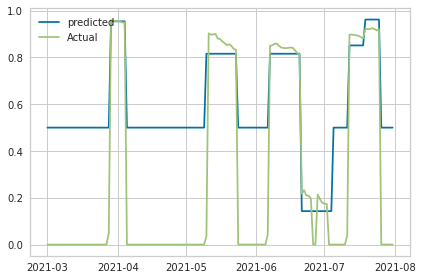

In [180]:
plt.plot(df_model.pos_busn_dt,binom_glm.predict(binom_results.params),label = "predicted")
plt.plot(df_model.pos_busn_dt,y_train,label = "Actual")
plt.legend()
plt.show()

In [177]:
y_pred = binom_glm.predict(binom_results.params)

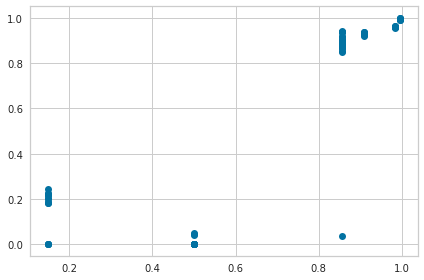

In [178]:
plt.plot(y_pred,y_train_new,"o")